# Data Description :
 * One challenge of modeling retail data is the need to make decisions based on limited history. If Christmas comes but once a year, so does the chance to see how strategic decisions impacted the bottom line.
 * You are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and you are tasked with predicting the department-wide sales for each store.

* In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

**stores.csv :**

This file contains anonymized information about the 45 stores, indicating the type and size of store.

**train.csv :**

This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file you will find the following fields:

**Store** - the store number
**Dept** - the department number
**Date** - the week
**Weekly_Sales** -  sales for the given department in the given store
**IsHoliday** - whether the week is a special holiday week

**test.csv :**

This file is identical to train.csv, except we have withheld the weekly sales. You must predict the sales for each triplet of store, department, and date in this file.

**features.csv :**

This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:

**Store** - the store number.

**Date** - the week.

**Temperature** - average temperature in the region.

**Fuel_Price** - cost of fuel in the region.

**MarkDown1-5** - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.

**CPI** - the consumer price index.

**Unemployment** - the unemployment rate.

**IsHoliday** - whether the week is a special holiday week

For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13
# ML Problem Formulation
<p><b> Time-series forecasting and Regression</b></p>
<br>
-<i> To predict the sales for each department in each store.</i>
<p> 
 Holiday markdown events are included in the dataset. These markdowns are known to affect sales, but it is challenging to predict which departments are affected and the extent of the impact..
</p>

# Objective :
 * To predict the department-wide sales for each store based on historical sales data.

# Performance metrics
**weighted mean absolute error (WMAE):**

where

$$ {WMAE} = \frac{1}{\sum{w_i}} \sum_{i=1}^n w_i | y_i - \hat{y}_i $$

**n** is the number of rows.

**y^i** is the predicted sales

**yi** is the actual sales

**wi** are weights. 

**w** = 5 if the week is a holiday week, 1 otherwise

## Importing Data and Necessary Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from prettytable import PrettyTable
from xgboost import XGBRegressor
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')

## Reading Data:

In [ ]:
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
stores.head()

Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875

In [ ]:
df.head()

Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

In [ ]:
features.head()

Store        Date  Temperature  ...         CPI  Unemployment  IsHoliday
0      1  2010-02-05        42.31  ...  211.096358         8.106      False
1      1  2010-02-12        38.51  ...  211.242170         8.106       True
2      1  2010-02-19        39.93  ...  211.289143         8.106      False
3      1  2010-02-26        46.63  ...  211.319643         8.106      False
4      1  2010-03-05        46.50  ...  211.350143         8.106      False

[5 rows x 12 columns]

In [ ]:
df_stores = pd.merge(df,stores,on='Store',how='left')
test_stores = pd.merge(test,stores,on='Store',how='left')
df_final = df_stores.merge(features,how='left')
test_final = test_stores.merge(features,how='left')
df_final.Date = pd.to_datetime(df_final.Date)
test_final.Date = pd.to_datetime(test_final.Date)

In [ ]:
df_final.head()

Store  Dept       Date  ...  MarkDown5         CPI Unemployment
0      1     1 2010-02-05  ...        NaN  211.096358        8.106
1      1     1 2010-02-12  ...        NaN  211.242170        8.106
2      1     1 2010-02-19  ...        NaN  211.289143        8.106
3      1     1 2010-02-26  ...        NaN  211.319643        8.106
4      1     1 2010-03-05  ...        NaN  211.350143        8.106

[5 rows x 16 columns]

In [ ]:
test_final.head()

Store  Dept       Date  ...  MarkDown5         CPI  Unemployment
0      1     1 2012-11-02  ...    2737.42  223.462779         6.573
1      1     1 2012-11-09  ...    6154.16  223.481307         6.573
2      1     1 2012-11-16  ...    6612.69  223.512911         6.573
3      1     1 2012-11-23  ...     303.32  223.561947         6.573
4      1     1 2012-11-30  ...    6966.34  223.610984         6.573

[5 rows x 15 columns]

# Data Analysis:

## Preliminary Observations on data :

In [ ]:
print('Basic description of our numerical features in our Train data :\n')
df_final.describe()

Basic description of our numerical features in our Train data :



Store           Dept  ...            CPI   Unemployment
count  421570.000000  421570.000000  ...  421570.000000  421570.000000
mean       22.200546      44.260317  ...     171.201947       7.960289
std        12.785297      30.492054  ...      39.159276       1.863296
min         1.000000       1.000000  ...     126.064000       3.879000
25%        11.000000      18.000000  ...     132.022667       6.891000
50%        22.000000      37.000000  ...     182.318780       7.866000
75%        33.000000      74.000000  ...     212.416993       8.572000
max        45.000000      99.000000  ...     227.232807      14.313000

[8 rows x 13 columns]

In [ ]:
print('Basic description of our numerical features in our Test data :\n')
test_final.describe()

Store           Dept  ...           CPI  Unemployment
count  115064.000000  115064.000000  ...  76902.000000  76902.000000
mean       22.238207      44.339524  ...    176.961347      6.868733
std        12.809930      30.656410  ...     41.239967      1.583427
min         1.000000       1.000000  ...    131.236226      3.684000
25%        11.000000      18.000000  ...    138.402033      5.771000
50%        22.000000      37.000000  ...    192.304445      6.806000
75%        33.000000      74.000000  ...    223.244532      8.036000
max        45.000000      99.000000  ...    228.976456     10.199000

[8 rows x 12 columns]

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null datetime64[ns]
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
Type            421570 non-null object
Size            421570 non-null int64
Temperature     421570 non-null float64
Fuel_Price      421570 non-null float64
MarkDown1       150681 non-null float64
MarkDown2       111248 non-null float64
MarkDown3       137091 non-null float64
MarkDown4       134967 non-null float64
MarkDown5       151432 non-null float64
CPI             421570 non-null float64
Unemployment    421570 non-null float64
dtypes: bool(1), datetime64[ns](1), float64(10), int64(3), object(1)
memory usage: 71.9+ MB


In [ ]:
print('There are total {} number of Observations & Having {} number of variables in Train data'.format(df_final.shape[0],df_final.shape[1]))
print('There are total {} number of Observations & Having {} number of variables in Test data'.format(test_final.shape[0],test_final.shape[1]))

There are total 421570 number of Observations & Having 16 number of variables in Train data
There are total 115064 number of Observations & Having 15 number of variables in Test data


In [ ]:
print('Data in Train data is from {} to {}'.format(df_final.Date.min(),df_final.Date.max()))
print('Data in Train data is from {} to {}'.format(test_final.Date.min(),test_final.Date.min()))

Data in Train data is from 2010-02-05 00:00:00 to 2012-10-26 00:00:00
Data in Train data is from 2012-11-02 00:00:00 to 2012-11-02 00:00:00


In [ ]:
df_final.Date.min(),df_final.Date.max()

(Timestamp('2010-02-05 00:00:00'), Timestamp('2012-10-26 00:00:00'))

In [ ]:
test.Date.min(),test.Date.max(),test.shape

('2012-11-02', '2013-07-26', (115064, 4))

In [ ]:
## Checking for duplicates
df_final.duplicated().any()

False

In [ ]:
print('_'*40)
print('Number of missing values per variable :')
print('_'*40)
df_final.isnull().sum()

________________________________________
Number of missing values per variable :
________________________________________


Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
dtype: int64

In [ ]:
print('Number of sales less than zero :',(df_final.Weekly_Sales<0).sum())

Number of sales less than zero : 1285


## Data Analysis

In [ ]:
def cmpr(x,size=(12,4),spc=0.2):
  fig,ax = plt.subplots(1,2,figsize=size)
  plt.subplots_adjust(wspace=spc)
  sns.countplot(y=x,data=df_final,order=df_final[x].value_counts().index,ax=ax[0])
  i=df_final.groupby(x)['Weekly_Sales'].sum().sort_values()[::-1]
  sns.violinplot(x=x,y='Weekly_Sales',ax=ax[1],data=df_final,order=i.index);
  plt.grid()
  
def corr(col):
  ax=sns.heatmap(df_final[[col,'Weekly_Sales']].corr(),annot=True);
  plt.title('Correlation between %s and Weekly_Sales'%(col));
  plt.setp(ax.get_yticklabels(),rotation=0); 

### Size:

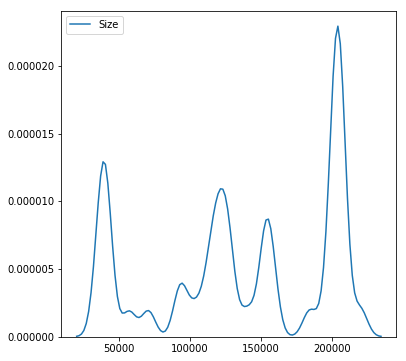

In [ ]:
plt.figure(figsize=(6,6))
sns.kdeplot(df_final.Size,);

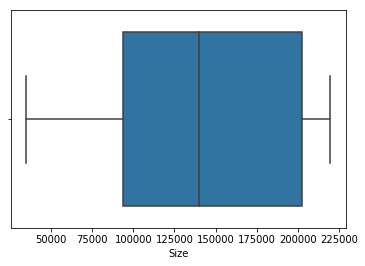

In [ ]:
sns.boxplot(df_final.Size,);

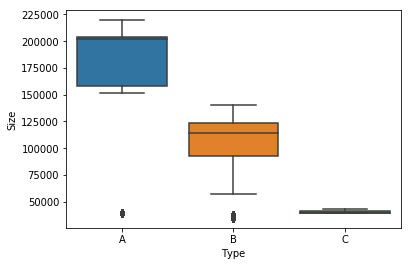

In [ ]:
sns.boxplot(x='Type',y='Size',data=df_final);

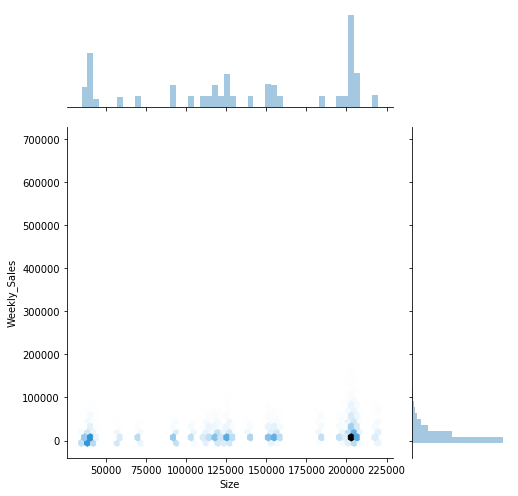

In [ ]:
sns.jointplot(x='Size', y="Weekly_Sales", data=df_final ,kind='hex',height=7, ratio=3);

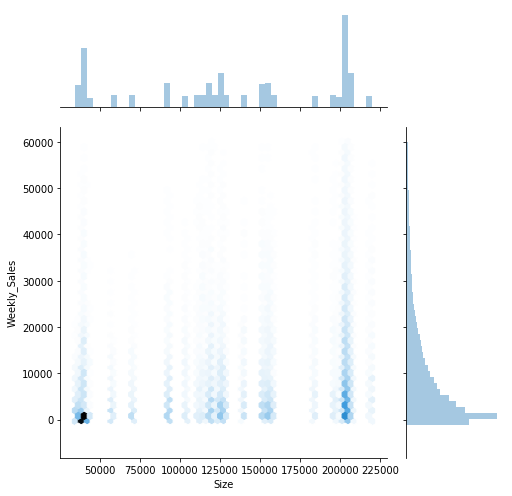

In [ ]:
sns.jointplot(x='Size', y="Weekly_Sales", data=df_final[df_final.Weekly_Sales<60000] ,kind='hex',height=7, ratio=3);

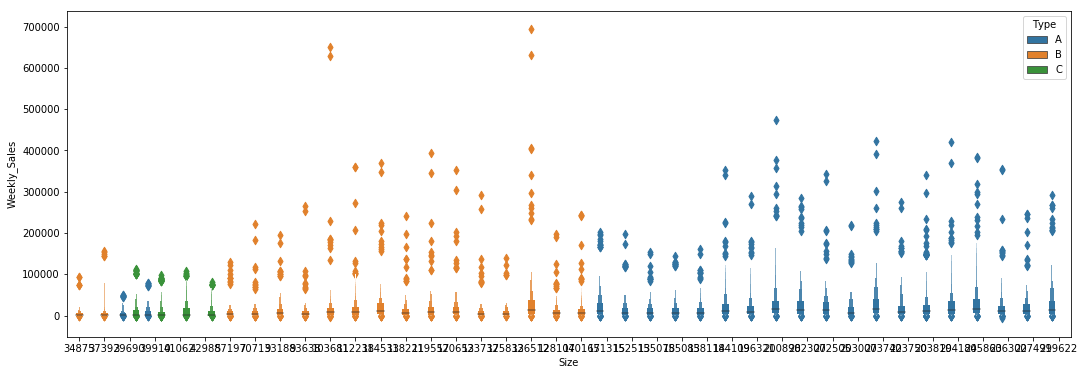

In [ ]:
plt.figure(figsize=(18,6));
sns.boxenplot(y='Weekly_Sales',x='Size',data=df_final,hue='Type');

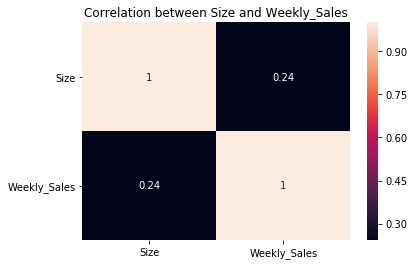

In [ ]:
corr('Size')

**Observations :**
* Size can be defferentiated by Type.
* Type 'A' and 'B' are not less than of size 50000 mostly, we can change it's type to 'C' if size is than 50000.
* Size is slightly correlated with weekly sales positively.
* bigger size of store doesn't leads to increase sales.

### Type:

In [ ]:
df_final.Type.value_counts()

A    215478
B    163495
C     42597
Name: Type, dtype: int64

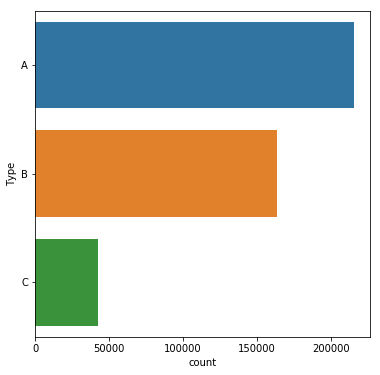

In [ ]:
plt.figure(figsize=(6,6))
sns.countplot(y='Type',data=df_final,order=df_final['Type'].value_counts().index);

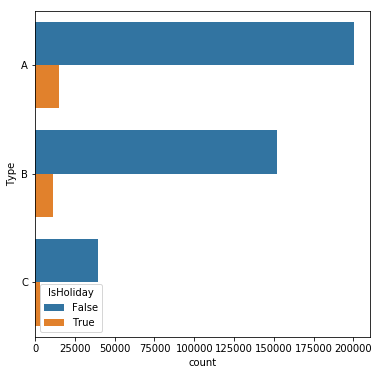

In [ ]:
plt.figure(figsize=(6,6))
sns.countplot(y='Type',data=df_final,order=df_final['Type'].value_counts().index,hue='IsHoliday',);
#sns.countplot(y='Dept',data=df_final,order=df_final['Dept'].value_counts().index);

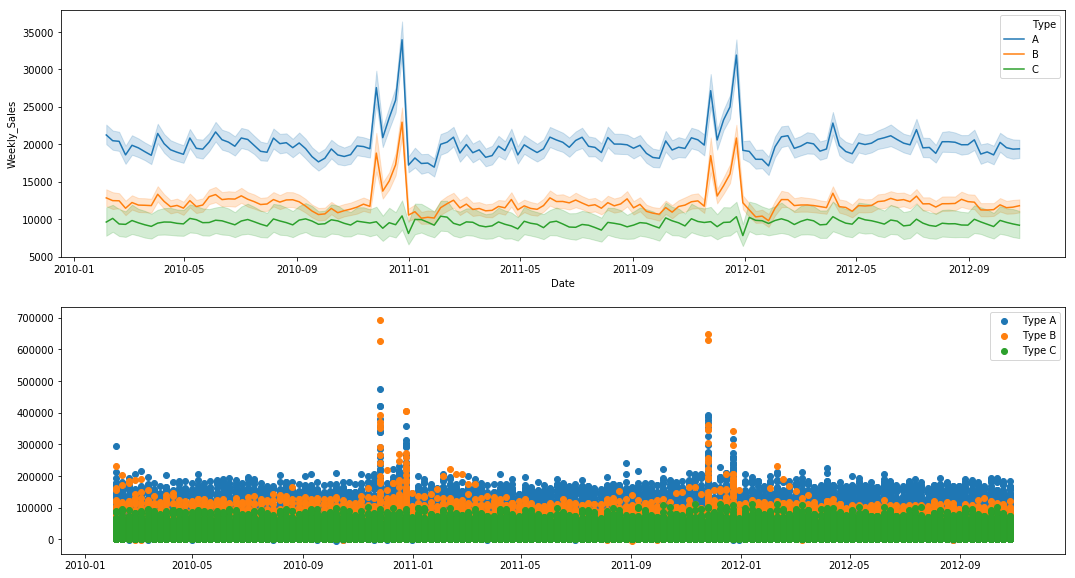

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(18,10))
#plt.figure(figsize=(20,5))
sns.lineplot(x='Date',y='Weekly_Sales',data=df_final,hue='Type',ax=ax[0]);

#plt.figure(figsize=(20,5))
ax[1].scatter(y=df_final[df_final.Type=='A'].Weekly_Sales,x=df_final[df_final.Type=='A'].Date,label='Type A');
ax[1].scatter(y=df_final[df_final.Type=='B'].Weekly_Sales,x=df_final[df_final.Type=='B'].Date,label='Type B');
ax[1].scatter(y=df_final[df_final.Type=='C'].Weekly_Sales,x=df_final[df_final.Type=='C'].Date,label='Type C');
plt.legend();

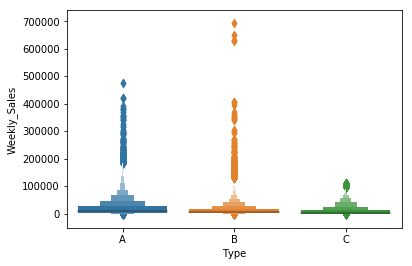

In [ ]:
sns.boxenplot(x='Type',y='Weekly_Sales',data=df_final);

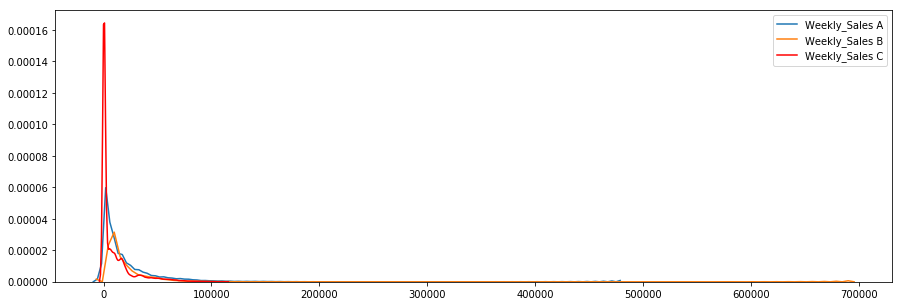

In [ ]:
plt.figure(figsize=(15,5))
sns.kdeplot(df_final[df_final.Type=='A'].Weekly_Sales,label='Weekly_Sales A')
sns.kdeplot(df_final[df_final.Type=='B'].Weekly_Sales,label='Weekly_Sales B')
sns.kdeplot(df_final[df_final.Type=='C'].Weekly_Sales,label='Weekly_Sales C',color='r');

In [ ]:
i=df_final.groupby('Type')['Weekly_Sales'].sum().sort_values()[::-1]
tmp=pd.DataFrame({'Type':i.index,'Total Sales':i.values})
tmp

Type   Total Sales
0    A  4.331015e+09
1    B  2.000701e+09
2    C  4.055035e+08

**Observations :**
* Weekly sales are clearly differentiable for each type of stores.
* Mean sales for type 'A' is highest, nearly half of type 'A' sales is equal to type 'B' sales, and type 'C' sales is lowest among other types
* Mostly type 'C' sales are less when compared to type 'B' and 'C' which have high values of sales

### Store

In [ ]:
df_final.Store.nunique()

45

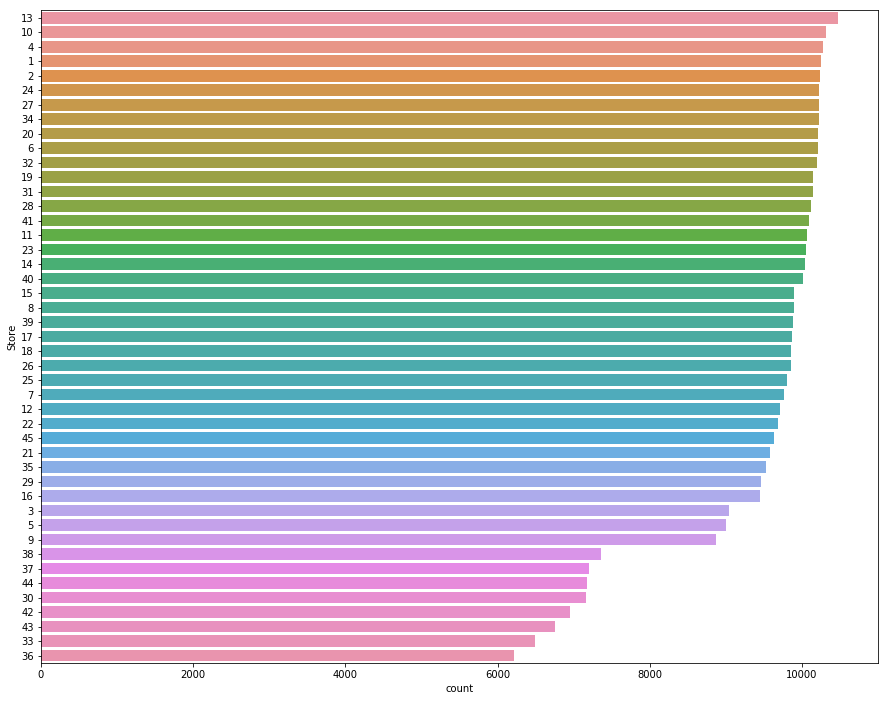

In [ ]:
plt.figure(figsize=(15,12))
sns.countplot(y='Store',data=df_final,order=df_final['Store'].value_counts().index);

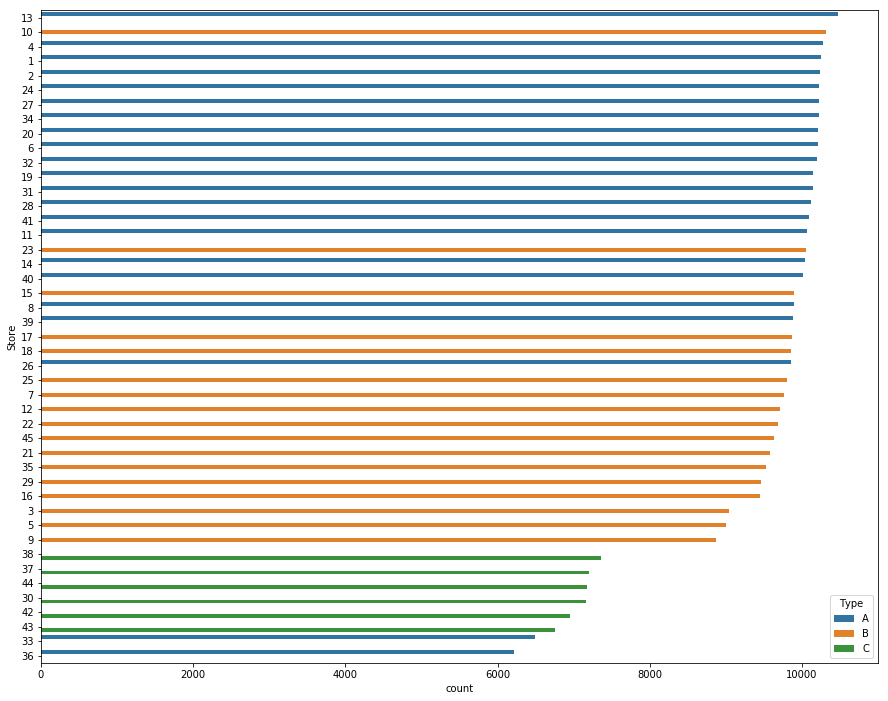

In [ ]:
plt.figure(figsize=(15,12))
sns.countplot(y='Store',data=df_final,order=df_final['Store'].value_counts().index,hue='Type');

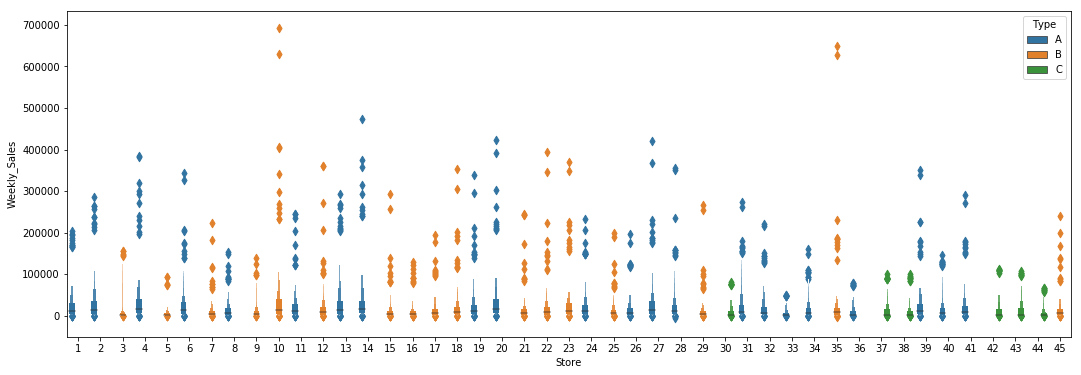

In [ ]:
plt.figure(figsize=(18,6));
sns.boxenplot(y='Weekly_Sales',x='Store',data=df_final,hue='Type');

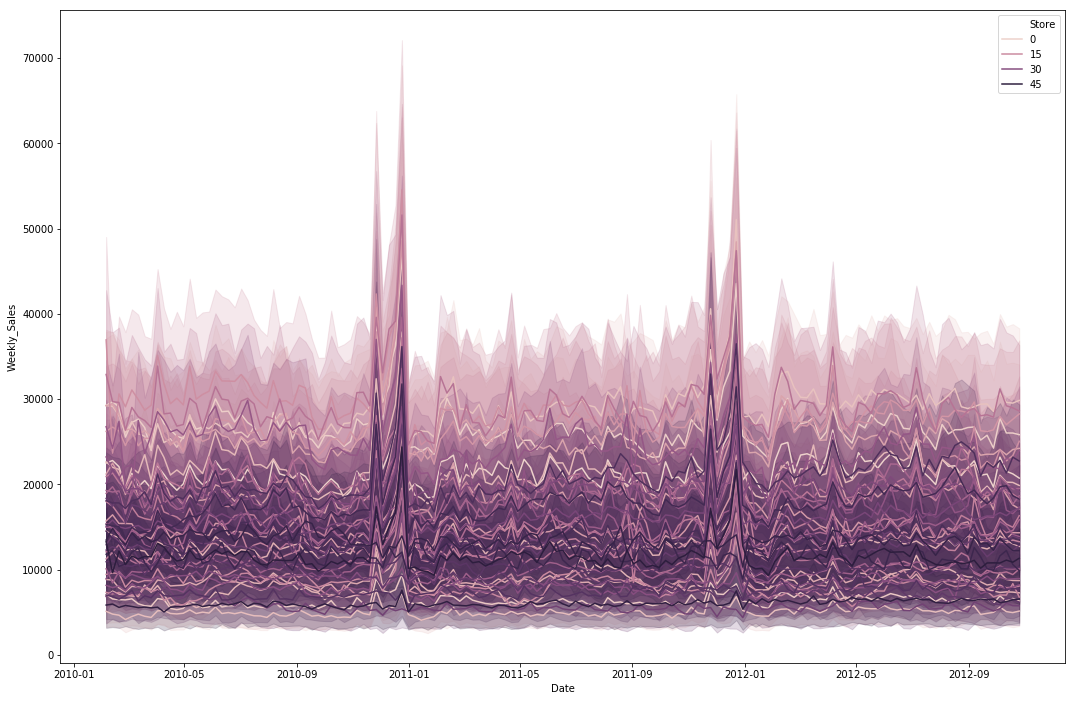

In [ ]:
plt.figure(figsize=(18,12))
sns.lineplot(x='Date',y='Weekly_Sales',data=df_final,hue='Store');

In [ ]:
i=df_final.groupby('Store')['Weekly_Sales'].sum().sort_values()[::-1]
tmp=pd.DataFrame({'Store':i.index,'Total Sales':i.values})
tmp['Type']= tmp.Store.map(dict(zip(df_final.Store,df_final.Type)))
tmp

Store   Total Sales Type
0      20  3.013978e+08    A
1       4  2.995440e+08    A
2      14  2.889999e+08    A
3      13  2.865177e+08    A
4       2  2.753824e+08    A
5      10  2.716177e+08    B
6      27  2.538559e+08    A
7       6  2.237561e+08    A
8       1  2.224028e+08    A
9      39  2.074455e+08    A
10     19  2.066349e+08    A
11     31  1.996139e+08    A
12     23  1.987506e+08    B
13     24  1.940160e+08    A
14     11  1.939628e+08    A
15     28  1.892637e+08    A
16     41  1.813419e+08    A
17     32  1.668192e+08    A
18     18  1.551147e+08    B
19     22  1.470756e+08    B
20     12  1.442872e+08    B
21     26  1.434164e+08    A
22     34  1.382498e+08    A
23     40  1.378703e+08    A
24     35  1.315207e+08    B
25      8  1.299512e+08    A
26     17  1.277821e+08    B
27     45  1.123953e+08    B
28     21  1.081179e+08    B
29     25  1.010612e+08    B
30     43  9.056544e+07    C
31     15  8.913368e+07    B
32      7  8.159828e+07    B
33     42  7.956575e+07    C
34      9  7.778922e+07    B
35     29  7.714155e+07    B
36     16  7.425243e+07    B
37     37  7.420274e+07    C
38     30  6.271689e+07    C
39      3  5.758674e+07    B
40     38  5.515963e+07    C
41     36  5.341221e+07    A
42      5  4.547569e+07    B
43     44  4.329309e+07    C
44     33  3.716022e+07    A

**Observations :**
* Stores are clearly differentiable by Type.
* Mostly sales are from type 'A' stores followed by 'B', and lowest from type 'C' stores.
* Not all stores sales are effected equally  during holidays.
* Effect of holidays are less for some stores.

### Department:

In [ ]:
df_final.Dept.nunique()

81

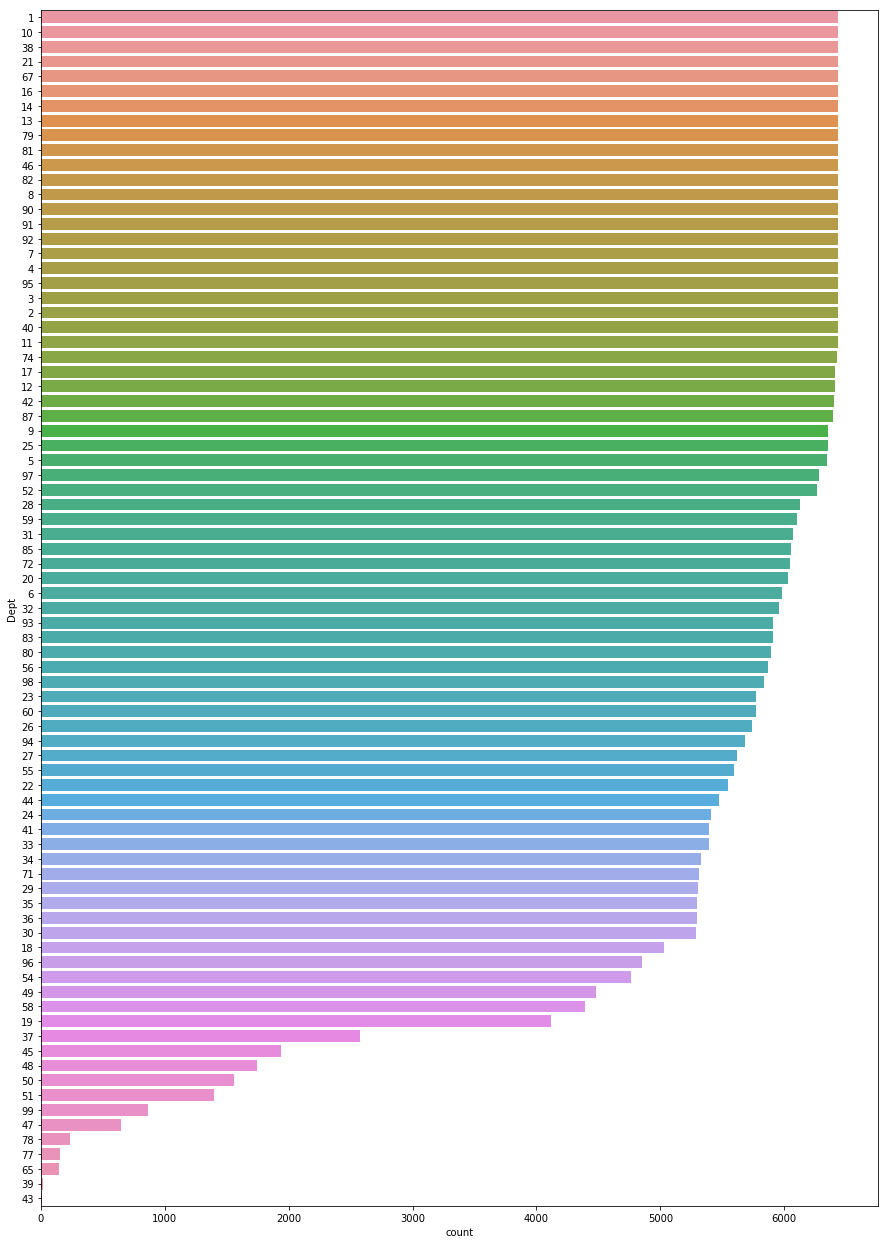

In [ ]:
plt.figure(figsize=(15,22))
sns.countplot(y='Dept',data=df_final,order=df_final['Dept'].value_counts().index);

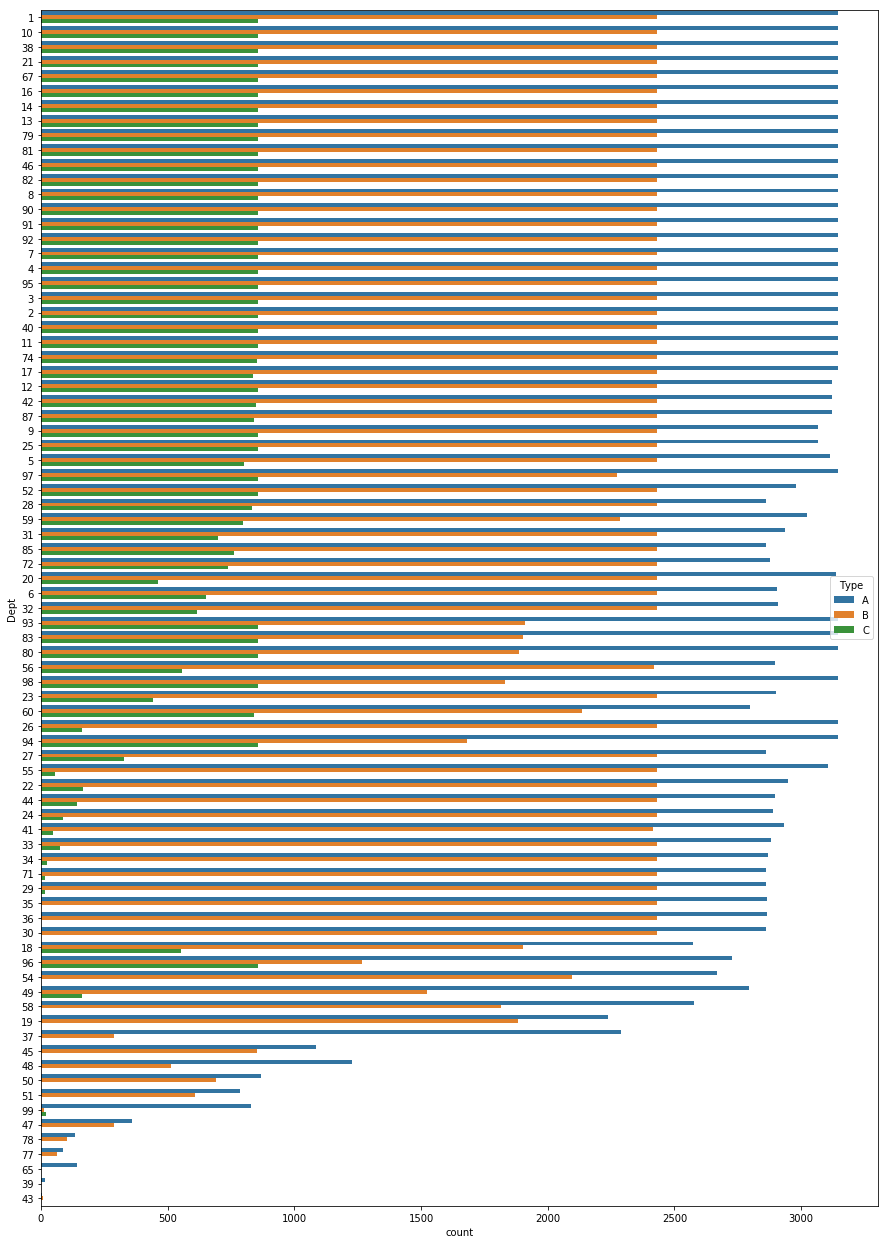

In [ ]:
plt.figure(figsize=(15,22))
sns.countplot(y='Dept',data=df_final,order=df_final['Dept'].value_counts().index,hue='Type');
#sns.countplot(y='Dept',data=df_final,order=df_final['Dept'].value_counts().index);

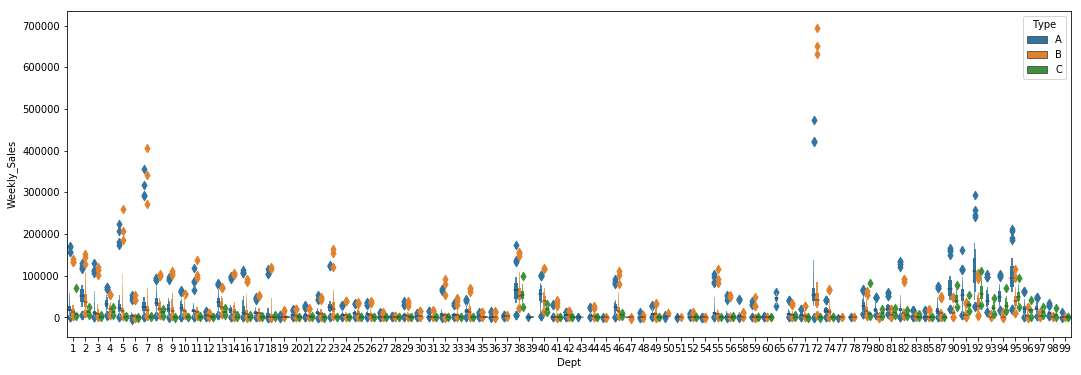

In [ ]:
plt.figure(figsize=(18,6));
sns.boxenplot(y='Weekly_Sales',x='Dept',data=df_final,hue='Type');

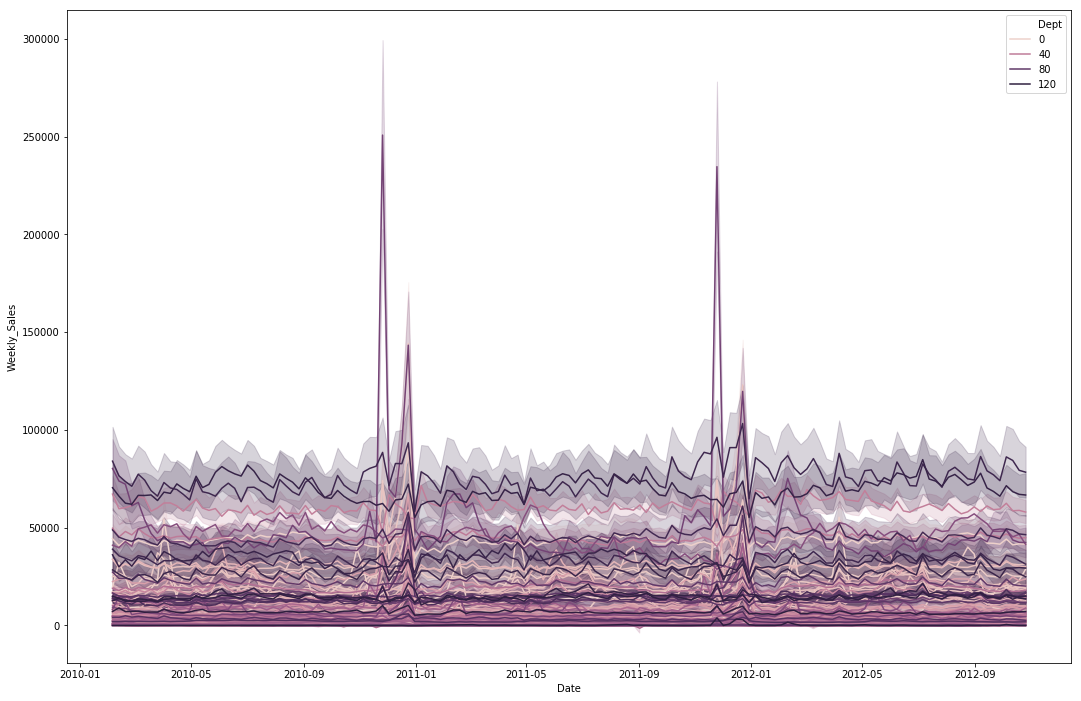

In [ ]:
plt.figure(figsize=(18,12))
sns.lineplot(x='Date',y='Weekly_Sales',data=df_final,hue='Dept');

In [ ]:
i=df_final.groupby('Dept')['Weekly_Sales'].sum().sort_values()[::-1]
tmp=pd.DataFrame({'Dept':i.index,'Total Sales':i.values})
#tmp['Counts'] = tmp.Dept.map(dict(zip(df_final.Dept.value_counts().index,df_final.Dept.value_counts().values)))
tmp

**Observations :**
* Totally there are 81 defferent Departments.
* Dept 92 and 95 being mostly contributed to sales compared to other departments.
* Dept 65 being lesser in total sales, range of sales is higher can be observed in sales & Dept boxplots above.
* As Stores Departments also aren't following same trend on holiday sales,
some departments are more sensitive to holidays as they are having highest sales during holidays compared to non holidays.

### IsHoliday:

In [ ]:
df_final.IsHoliday.value_counts()

False    391909
True      29661
Name: IsHoliday, dtype: int64

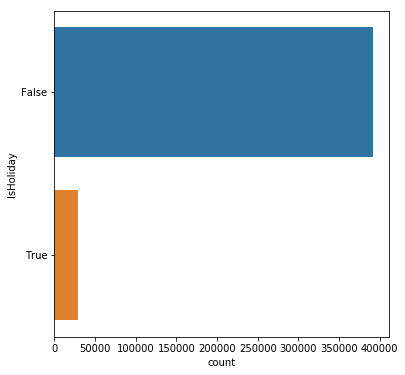

In [ ]:
plt.figure(figsize=(6,6))
sns.countplot(y='IsHoliday',data=df_final,order=df_final['IsHoliday'].value_counts().index);

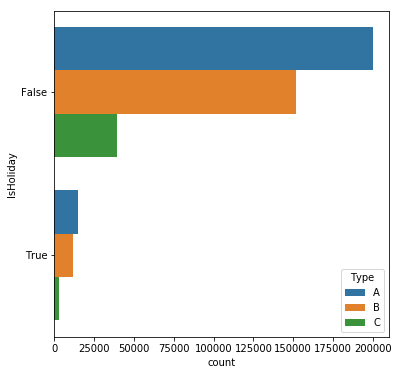

In [ ]:
plt.figure(figsize=(6,6))
sns.countplot(y='IsHoliday',data=df_final,order=df_final['IsHoliday'].value_counts().index,hue='Type');
#sns.countplot(y='Dept',data=df_final,order=df_final['Dept'].value_counts().index);

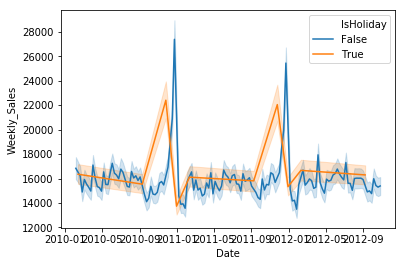

In [ ]:
sns.lineplot(x='Date',y='Weekly_Sales',data=df_final,hue='IsHoliday');

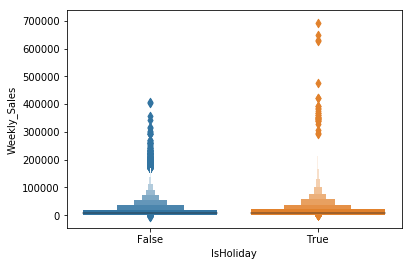

In [ ]:
sns.boxenplot(x='IsHoliday',y='Weekly_Sales',data=df_final);

In [ ]:
df_final[df_final.IsHoliday==True].Date.unique()

array(['2010-02-12T00:00:00.000000000', '2010-09-10T00:00:00.000000000',
       '2010-11-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000',
       '2011-02-11T00:00:00.000000000', '2011-09-09T00:00:00.000000000',
       '2011-11-25T00:00:00.000000000', '2011-12-30T00:00:00.000000000',
       '2012-02-10T00:00:00.000000000', '2012-09-07T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [ ]:
tmp=pd.DataFrame({'y':df_final[df_final.IsHoliday==True].Weekly_Sales,'x':df_final[df_final.IsHoliday==True].Date})

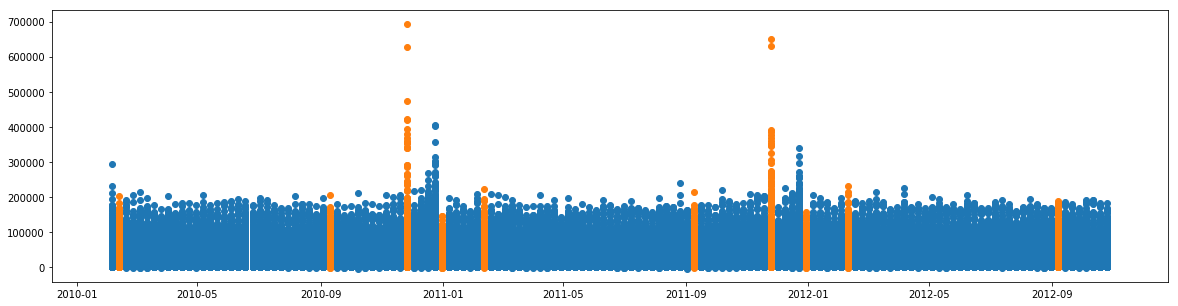

In [ ]:
plt.figure(figsize=(20,5))
plt.scatter(y=df_final[df_final.IsHoliday==False].Weekly_Sales,x=df_final[df_final.IsHoliday==False].Date);
plt.scatter(y=df_final[df_final.IsHoliday==True].Weekly_Sales,x=df_final[df_final.IsHoliday==True].Date);

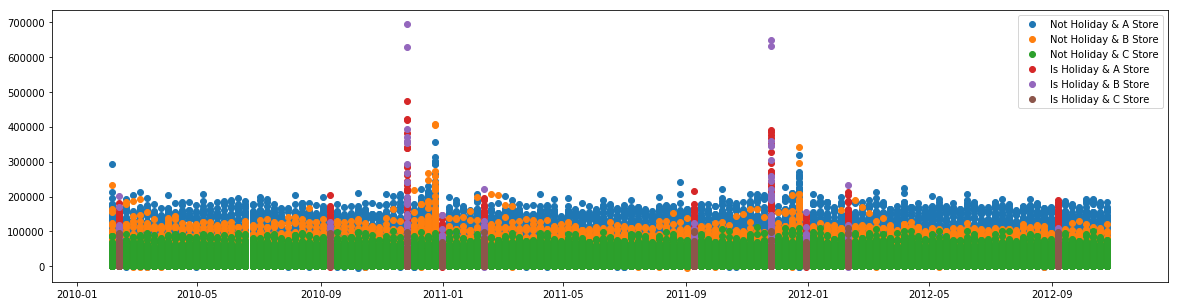

In [ ]:
plt.figure(figsize=(20,5))
plt.scatter(y=df_final[(df_final.IsHoliday==False)& (df_final.Type=='A')].Weekly_Sales,x=df_final[(df_final.IsHoliday==False) & (df_final.Type=='A')].Date,label='Not Holiday & A Store');
plt.scatter(y=df_final[(df_final.IsHoliday==False)& (df_final.Type=='B')].Weekly_Sales,x=df_final[(df_final.IsHoliday==False) & (df_final.Type=='B')].Date,label='Not Holiday & B Store');
plt.scatter(y=df_final[(df_final.IsHoliday==False)& (df_final.Type=='C')].Weekly_Sales,x=df_final[(df_final.IsHoliday==False) & (df_final.Type=='C')].Date,label='Not Holiday & C Store');


plt.scatter(y=df_final[(df_final.IsHoliday==True)& (df_final.Type=='A')].Weekly_Sales,x=df_final[(df_final.IsHoliday==True) & (df_final.Type=='A')].Date,label='Is Holiday & A Store');
plt.scatter(y=df_final[(df_final.IsHoliday==True)& (df_final.Type=='B')].Weekly_Sales,x=df_final[(df_final.IsHoliday==True) & (df_final.Type=='B')].Date,label='Is Holiday & B Store');
plt.scatter(y=df_final[(df_final.IsHoliday==True)& (df_final.Type=='C')].Weekly_Sales,x=df_final[(df_final.IsHoliday==True) & (df_final.Type=='C')].Date,label='Is Holiday & C Store');


plt.legend();

#plt.scatter(y=df_final[df_final.IsHoliday==True].Weekly_Sales,x=df_final[df_final.IsHoliday==True].Date);

In [ ]:
i=df_final.groupby('IsHoliday')['Weekly_Sales'].sum().sort_values()[::-1]
tmp=pd.DataFrame({'IsHoliday':i.index,'Total Sales':i.values})
tmp

IsHoliday   Total Sales
0     False  6.231919e+09
1      True  5.052996e+08

**Observations :**
* The sales are comparetively high on holidays compared to non holidays.
* Among all holidays on thanksgiving there are more sales compared to all.

### Temperature:

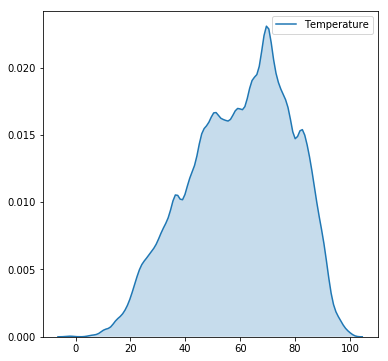

In [ ]:
plt.figure(figsize=(6,6))
sns.kdeplot(df_final.Temperature,shade=True);

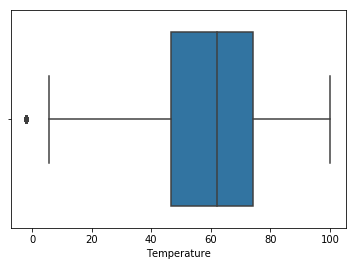

In [ ]:
sns.boxplot(df_final.Temperature,);

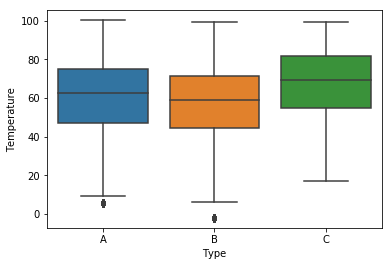

In [ ]:
sns.boxplot(x='Type',y='Temperature',data=df_final);

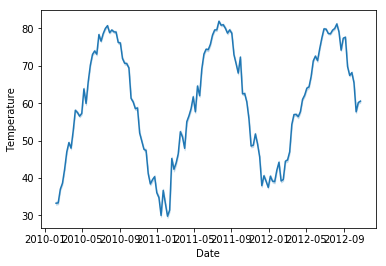

In [ ]:
sns.lineplot(x='Date', y="Temperature",data=df_final);

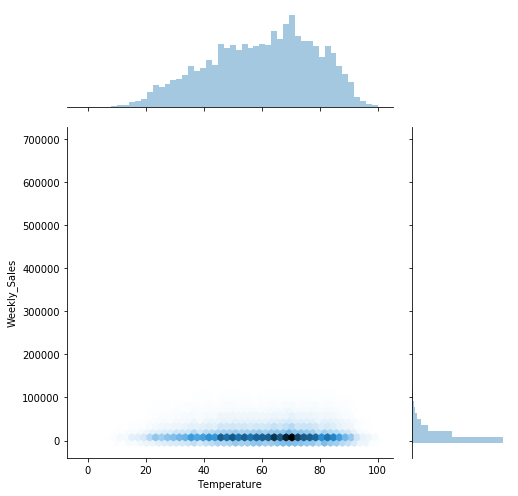

In [ ]:
sns.jointplot(x='Temperature', y="Weekly_Sales", data=df_final ,kind='hex',height=7, ratio=3);

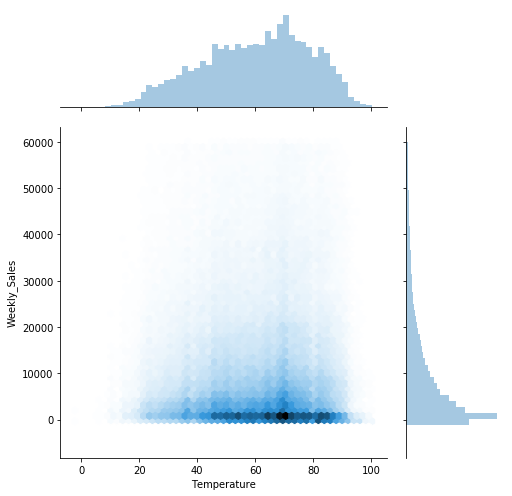

In [ ]:
sns.jointplot(x='Temperature', y="Weekly_Sales", data=df_final[df_final.Weekly_Sales<60000] ,kind='hex',height=7, ratio=3);

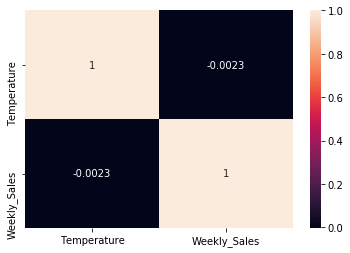

In [ ]:
sns.heatmap(df_final[['Temperature','Weekly_Sales']].corr(),annot=True);

**Observations :**
* Can't see any correlation between Temperature and sales

### Fuel_Price:

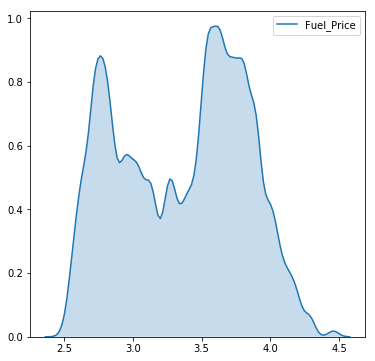

In [ ]:
plt.figure(figsize=(6,6))
sns.kdeplot(df_final.Fuel_Price,shade=True);
#sns.kdeplot(df_final.Temperature,shade=True,cumulative=True,);

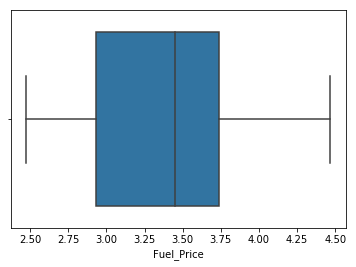

In [ ]:
sns.boxplot(df_final.Fuel_Price,);

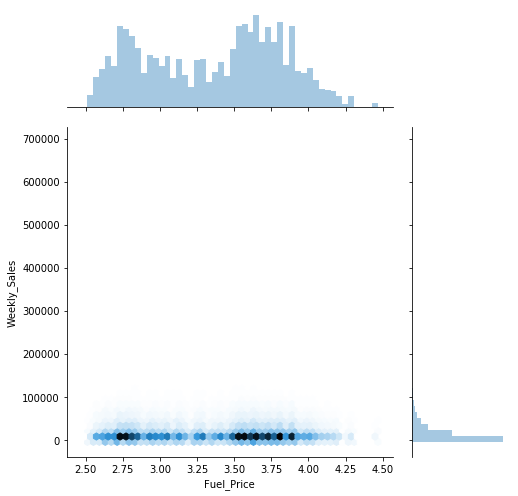

In [ ]:
sns.jointplot(x='Fuel_Price', y="Weekly_Sales", data=df_final ,kind='hex',height=7, ratio=3);

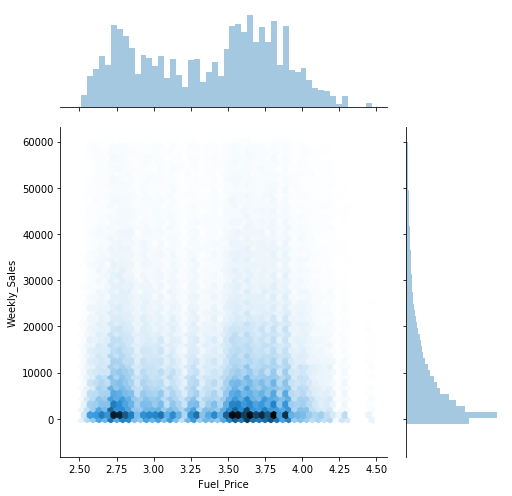

In [ ]:
sns.jointplot(x='Fuel_Price', y="Weekly_Sales", data=df_final[df_final.Weekly_Sales<60000] ,kind='hex',height=7, ratio=3);

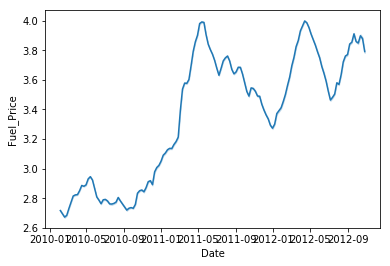

In [ ]:
sns.lineplot(x='Date', y="Fuel_Price",data=df_final);

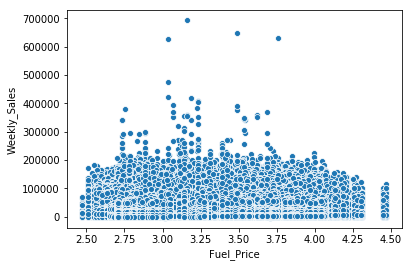

In [ ]:
sns.scatterplot(x='Fuel_Price', y="Weekly_Sales",data=df_final);

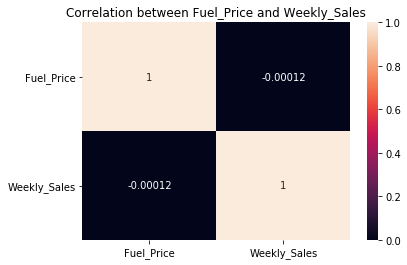

In [ ]:
corr('Fuel_Price')

**Observations :**
* Can't see any correlation between Fuel price and sales

### CPI:

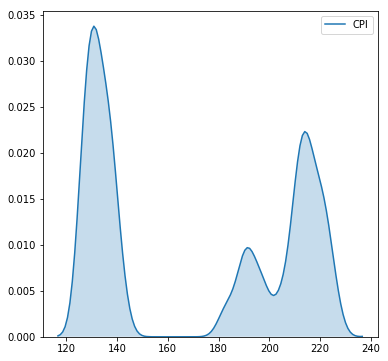

In [ ]:
plt.figure(figsize=(6,6))
sns.kdeplot(df_final.CPI,shade=True);
#sns.kdeplot(df_final.Temperature,shade=True,cumulative=True,);

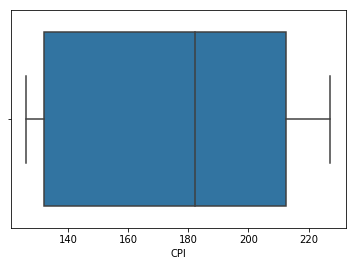

In [ ]:
sns.boxplot(df_final.CPI,);

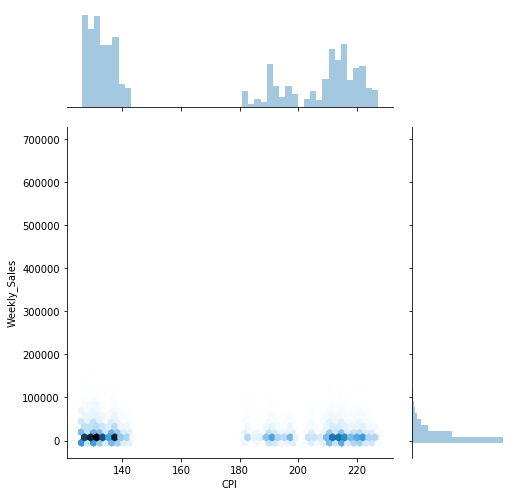

In [ ]:
sns.jointplot(x='CPI', y="Weekly_Sales", data=df_final ,kind='hex',height=7, ratio=3);

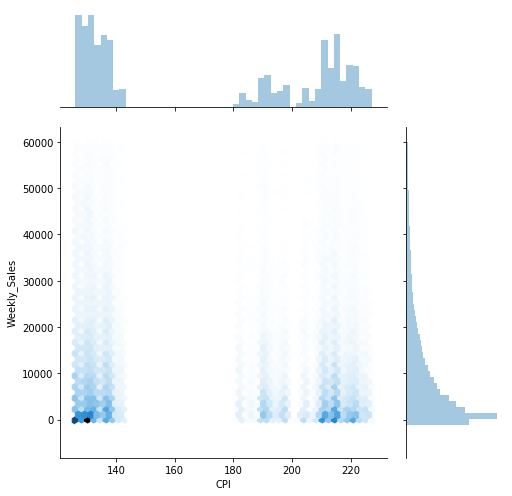

In [ ]:
sns.jointplot(x='CPI', y="Weekly_Sales", data=df_final[df_final.Weekly_Sales<60000] ,kind='hex',height=7, ratio=3);

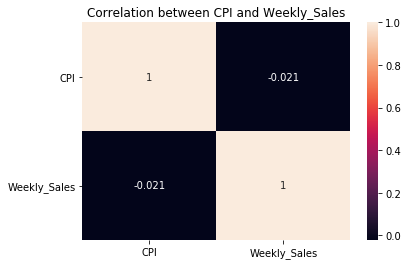

In [ ]:
corr('CPI')

**Observations :**
* Can't see any correlation between CPI and sales

### Unemployment:

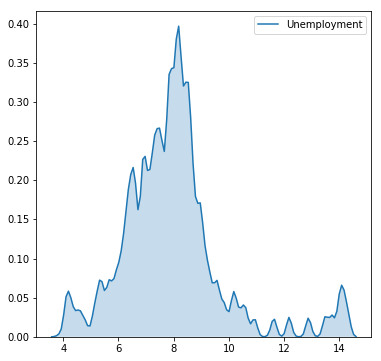

In [ ]:
plt.figure(figsize=(6,6))
sns.kdeplot(df_final.Unemployment,shade=True);
#sns.kdeplot(df_final.Temperature,shade=True,cumulative=True,);

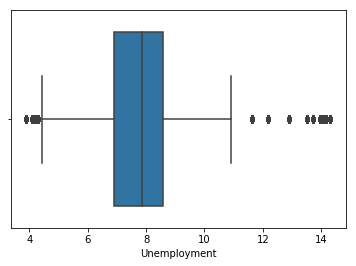

In [ ]:
sns.boxplot(df_final.Unemployment,);

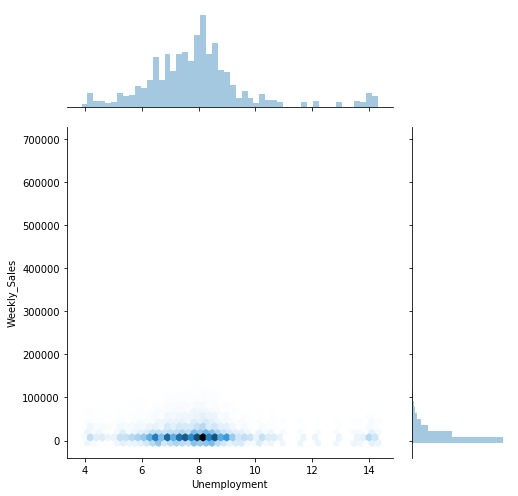

In [ ]:
sns.jointplot(x='Unemployment', y="Weekly_Sales", data=df_final ,kind='hex',height=7, ratio=3);

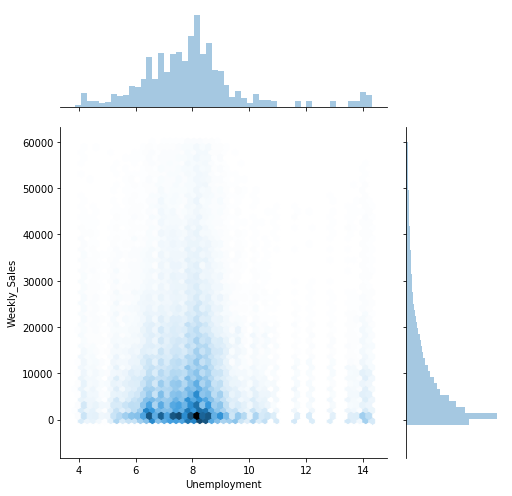

In [ ]:
sns.jointplot(x='Unemployment', y="Weekly_Sales", data=df_final[df_final.Weekly_Sales<60000] ,kind='hex',height=7, ratio=3);

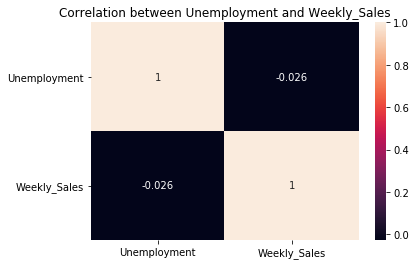

In [ ]:
corr('Unemployment')

**Observations :**
* There's no effect of Unemployment on sales.

### MarkDown1:

In [ ]:
df_final.MarkDown1.describe()

count    150681.000000
mean       7246.420196
std        8291.221345
min           0.270000
25%        2240.270000
50%        5347.450000
75%        9210.900000
max       88646.760000
Name: MarkDown1, dtype: float64

In [ ]:
print('Percentage of missing values in Markdown1 Variable is : %f '%(df_final.MarkDown1.isnull().sum()/len(df_final)*100))

Percentage of missing values in Markdown1 Variable is : 64.257181 


In [ ]:
df_final.MarkDown1.describe()

count    150681.000000
mean       7246.420196
std        8291.221345
min           0.270000
25%        2240.270000
50%        5347.450000
75%        9210.900000
max       88646.760000
Name: MarkDown1, dtype: float64

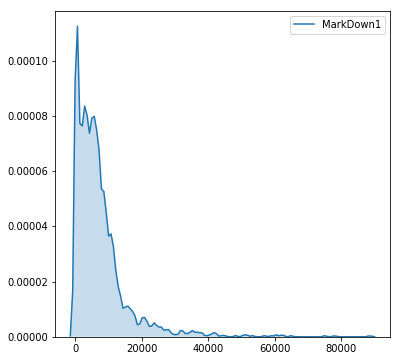

In [ ]:
plt.figure(figsize=(6,6))
sns.kdeplot(df_final.MarkDown1,shade=True);

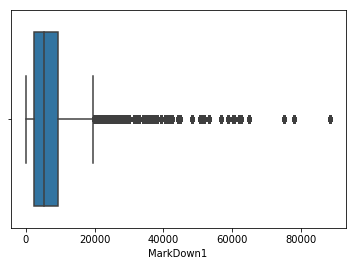

In [ ]:
sns.boxplot(df_final.MarkDown1,);

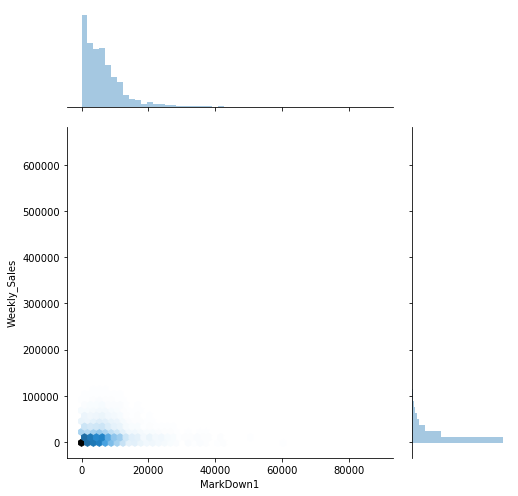

In [ ]:
sns.jointplot(x='MarkDown1', y="Weekly_Sales", data=df_final ,kind='hex',height=7, ratio=3);

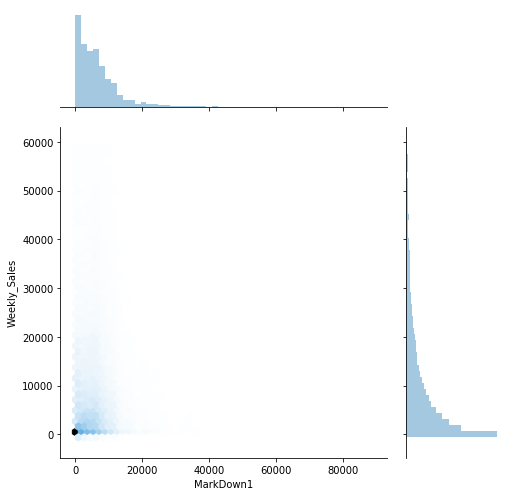

In [ ]:
sns.jointplot(x='MarkDown1', y="Weekly_Sales", data=df_final[df_final.Weekly_Sales<60000] ,kind='hex',height=7, ratio=3);

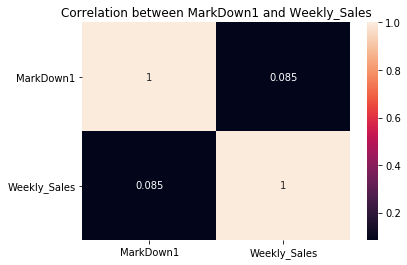

In [ ]:
corr('MarkDown1')

In [ ]:
tmp = df_final[df_final.MarkDown1.notnull()]
tmp['Weekly_Sales'] = tmp.Weekly_Sales.map(lambda x: x if x>0 else 1)
tmp = pd.DataFrame({'x':np.log(tmp.MarkDown1),'y':np.log(tmp.Weekly_Sales)})

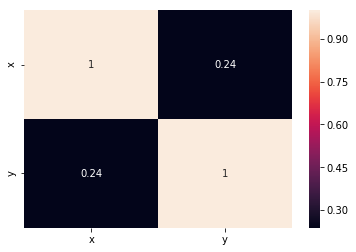

In [ ]:
sns.heatmap(annot=True,data=tmp.corr());

**Observations :**
* There are about 64% of total values of Markdown1 are missing.
* Distribution is mostly skewed to left as like sales
* Log transformation of both Markdown and sales increases correlation between them aroung three times

### MarkDown2:

In [ ]:
df_final.MarkDown2.describe()

count    111248.000000
mean       3334.628621
std        9475.357325
min        -265.760000
25%          41.600000
50%         192.000000
75%        1926.940000
max      104519.540000
Name: MarkDown2, dtype: float64

In [ ]:
print('Percentage of missing values in MarkDown2 Variable is : %f '%(df_final.MarkDown2.isnull().sum()/len(df_final)*100))

Percentage of missing values in MarkDown2 Variable is : 73.611025 


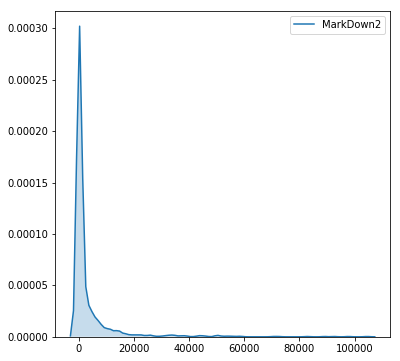

In [ ]:
plt.figure(figsize=(6,6))
sns.kdeplot(df_final[df_final.MarkDown2.notnull()].MarkDown2,shade=True);

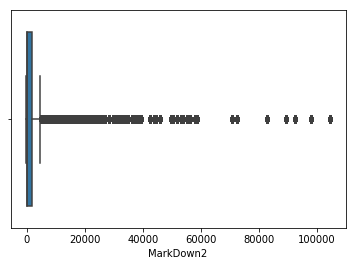

In [ ]:
sns.boxplot(df_final.MarkDown2,);

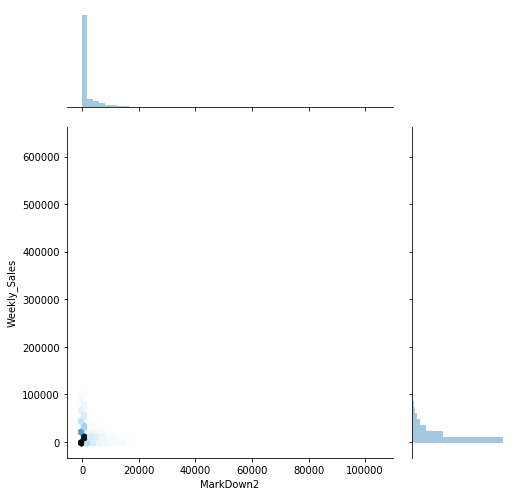

In [ ]:
sns.jointplot(x='MarkDown2', y="Weekly_Sales", data=df_final ,kind='hex',height=7, ratio=3);

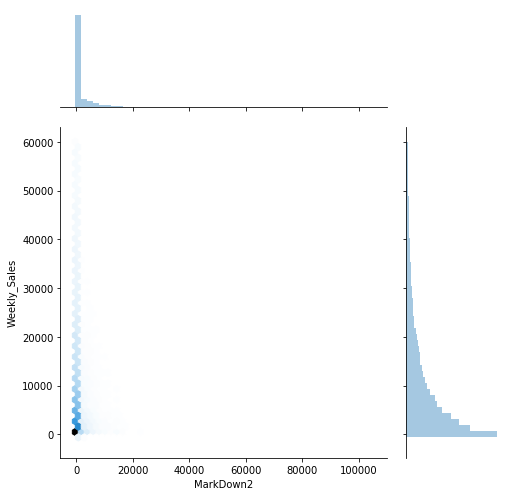

In [ ]:
sns.jointplot(x='MarkDown2', y="Weekly_Sales", data=df_final[df_final.Weekly_Sales<60000] ,kind='hex',height=7, ratio=3);

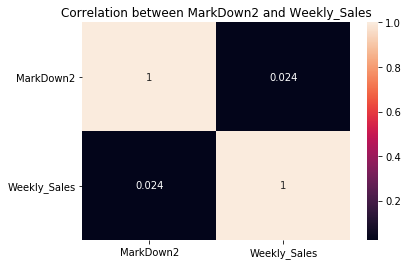

In [ ]:
corr('MarkDown2')

In [ ]:
tmp = df_final[df_final.MarkDown2.notnull()]
tmp['Weekly_Sales'] = tmp.Weekly_Sales.map(lambda x: x if x>0 else 1)
tmp = pd.DataFrame({'x':np.log(tmp.MarkDown2),'y':np.log(tmp.Weekly_Sales)})

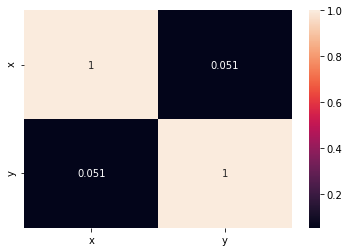

In [ ]:
sns.heatmap(annot=True,data=tmp.corr());

**Observations :**
* There are about 73.6 % of total values of Markdown2 are missing.
* Distribution is mostly skewed to left as like sales
* Log transformation of both Markdown2 and sales didn't improve in much correlation

### MarkDown3:

In [ ]:
df_final.MarkDown3.describe()

count    137091.000000
mean       1439.421384
std        9623.078290
min         -29.100000
25%           5.080000
50%          24.600000
75%         103.990000
max      141630.610000
Name: MarkDown3, dtype: float64

In [ ]:
print('Percentage of missing values in MarkDown3 Variable is : %f '%(df_final.MarkDown3.isnull().sum()/len(df_final)*100))

Percentage of missing values in MarkDown3 Variable is : 67.480845 


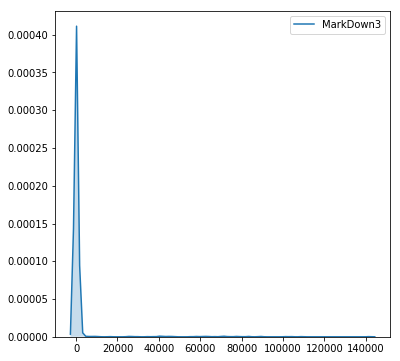

In [ ]:
plt.figure(figsize=(6,6))
sns.kdeplot(df_final[df_final.MarkDown3.notnull()].MarkDown3,shade=True);

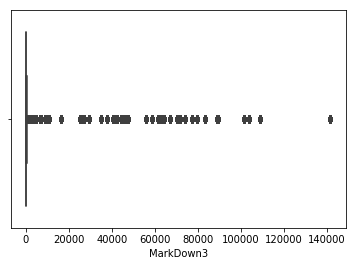

In [ ]:
sns.boxplot(df_final.MarkDown3,);

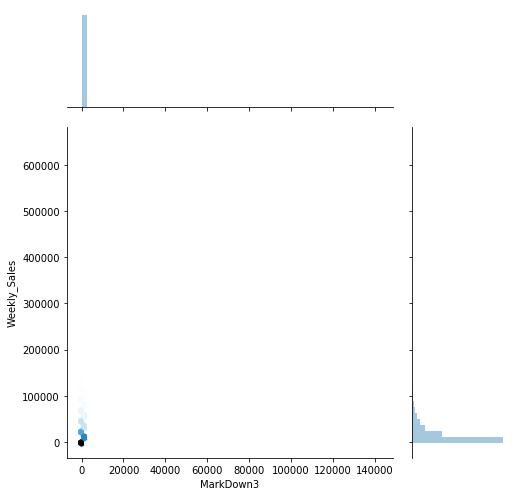

In [ ]:
sns.jointplot(x='MarkDown3', y="Weekly_Sales", data=df_final ,kind='hex',height=7, ratio=3);

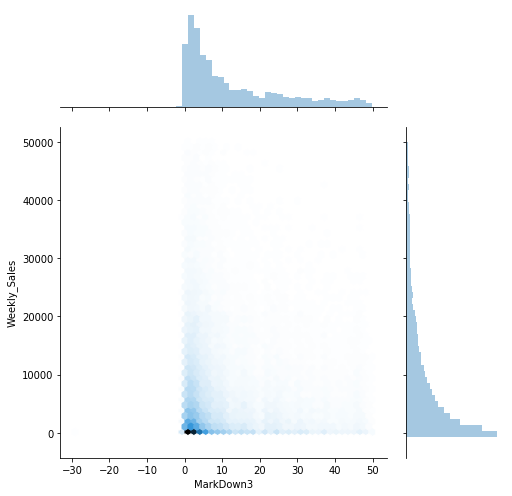

In [ ]:
sns.jointplot(x='MarkDown3', y="Weekly_Sales", data=df_final[(df_final.Weekly_Sales<50000) & (df_final.MarkDown3<50)] ,kind='hex',height=7, ratio=3);

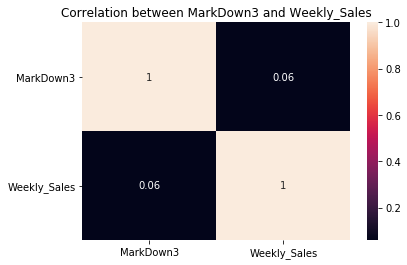

In [ ]:
corr('MarkDown3')

In [ ]:
tmp = df_final[df_final.MarkDown3.notnull()]
tmp['Weekly_Sales'] = tmp.Weekly_Sales.map(lambda x: x if x>0 else 1)
tmp = pd.DataFrame({'x':np.log(tmp.MarkDown3),'y':np.log(tmp.Weekly_Sales)})

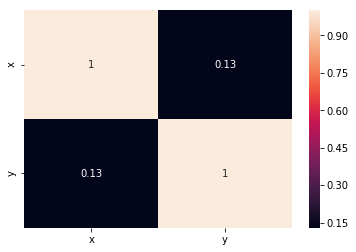

In [ ]:
sns.heatmap(annot=True,data=tmp.corr());

**Observations :**
* There are about 67% of total values of Markdown1 are missing.
* Distribution is mostly skewed to left as like sales
* Log transformation of both Markdown and sales increases correlation between them around two times, but still correlation is very less

### MarkDown4:

In [ ]:
df_final.MarkDown4.describe()

count    134967.000000
mean       3383.168256
std        6292.384031
min           0.220000
25%         504.220000
50%        1481.310000
75%        3595.040000
max       67474.850000
Name: MarkDown4, dtype: float64

In [ ]:
print('Percentage of missing values in MarkDown4 Variable is : %f '%(df_final.MarkDown4.isnull().sum()/len(df_final)*100))

Percentage of missing values in MarkDown4 Variable is : 67.984676 


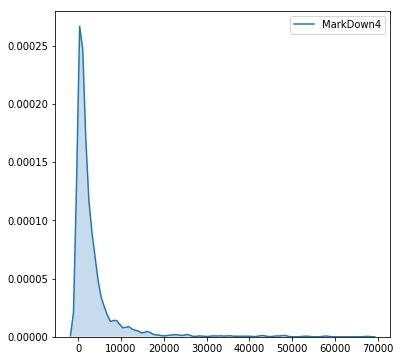

In [ ]:
plt.figure(figsize=(6,6))
sns.kdeplot(df_final[df_final.MarkDown4.notnull()].MarkDown4,shade=True);

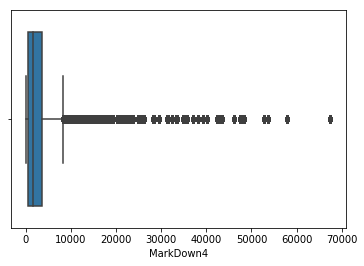

In [ ]:
sns.boxplot(df_final.MarkDown4,);

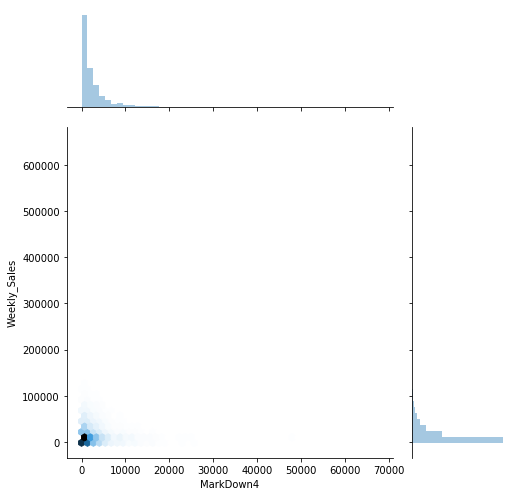

In [ ]:
sns.jointplot(x='MarkDown4', y="Weekly_Sales", data=df_final ,kind='hex',height=7, ratio=3);

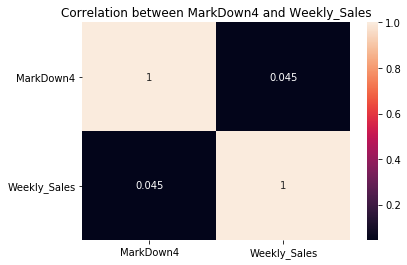

In [ ]:
corr('MarkDown4')

In [ ]:
tmp = df_final[df_final.MarkDown4.notnull()]
tmp['Weekly_Sales'] = tmp.Weekly_Sales.map(lambda x: x if x>0 else 1)
tmp = pd.DataFrame({'x':np.log(tmp.MarkDown4),'y':np.log(tmp.Weekly_Sales)})

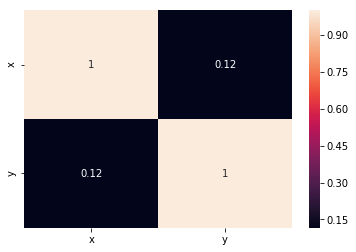

In [ ]:
sns.heatmap(annot=True,data=tmp.corr());

**Observations :**
* There are about 68 % of total values of Markdown1 are missing.
* Distribution is mostly skewed to left as like sales
* Log transformation of both Markdown and sales increases correlation between them aroung two times, but still there isn't much correlation between them.

### MarkDown5:

In [ ]:
df_final.MarkDown5.describe()

count    151432.000000
mean       4628.975079
std        5962.887455
min         135.160000
25%        1878.440000
50%        3359.450000
75%        5563.800000
max      108519.280000
Name: MarkDown5, dtype: float64

In [ ]:
print('Percentage of missing values in MarkDown5 Variable is : %f '%(df_final.MarkDown5.isnull().sum()/len(df_final)*100))

Percentage of missing values in MarkDown5 Variable is : 64.079038 


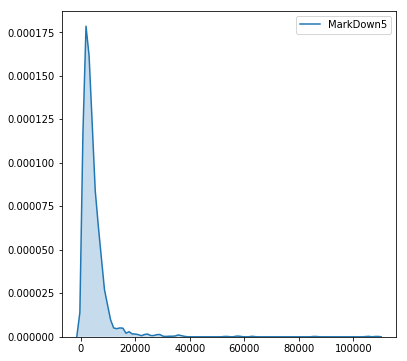

In [ ]:
plt.figure(figsize=(6,6))
sns.kdeplot(df_final[df_final.MarkDown5.notnull()].MarkDown5,shade=True);

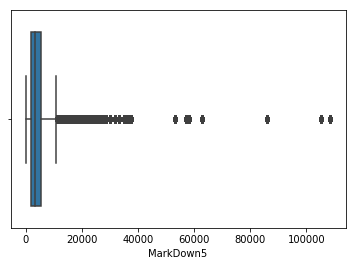

In [ ]:
sns.boxplot(df_final.MarkDown5,);

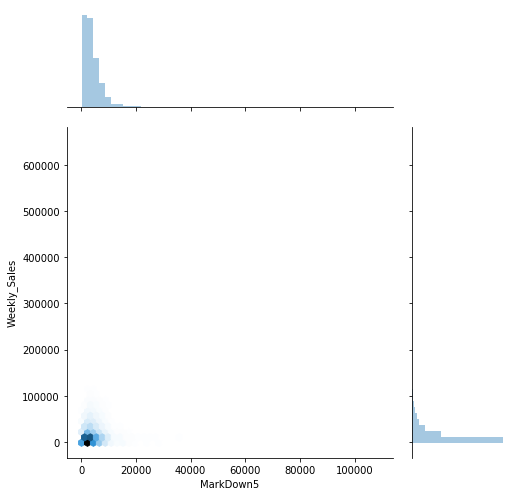

In [ ]:
sns.jointplot(x='MarkDown5', y="Weekly_Sales", data=df_final ,kind='hex',height=7, ratio=3);

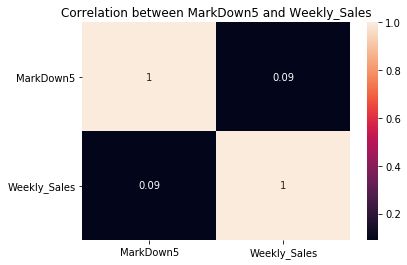

In [ ]:
corr('MarkDown5')

In [ ]:
tmp = df_final[df_final.MarkDown5.notnull()]
tmp['Weekly_Sales'] = tmp.Weekly_Sales.map(lambda x: x if x>0 else 1)
tmp = pd.DataFrame({'x':np.log(tmp.MarkDown5),'y':np.log(tmp.Weekly_Sales)})

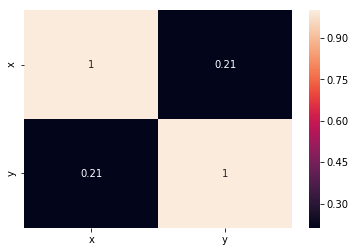

In [ ]:
sns.heatmap(annot=True,data=tmp.corr());

**Observations :**
* There are about 68 % of total values of Markdown1 are missing.
* Distribution is mostly skewed to left as like sales
* Log transformation of both Markdown and sales increases correlation between them aroung two times, but still there isn't much correlation between them.

## Dependence of Weekly sales on various factors :

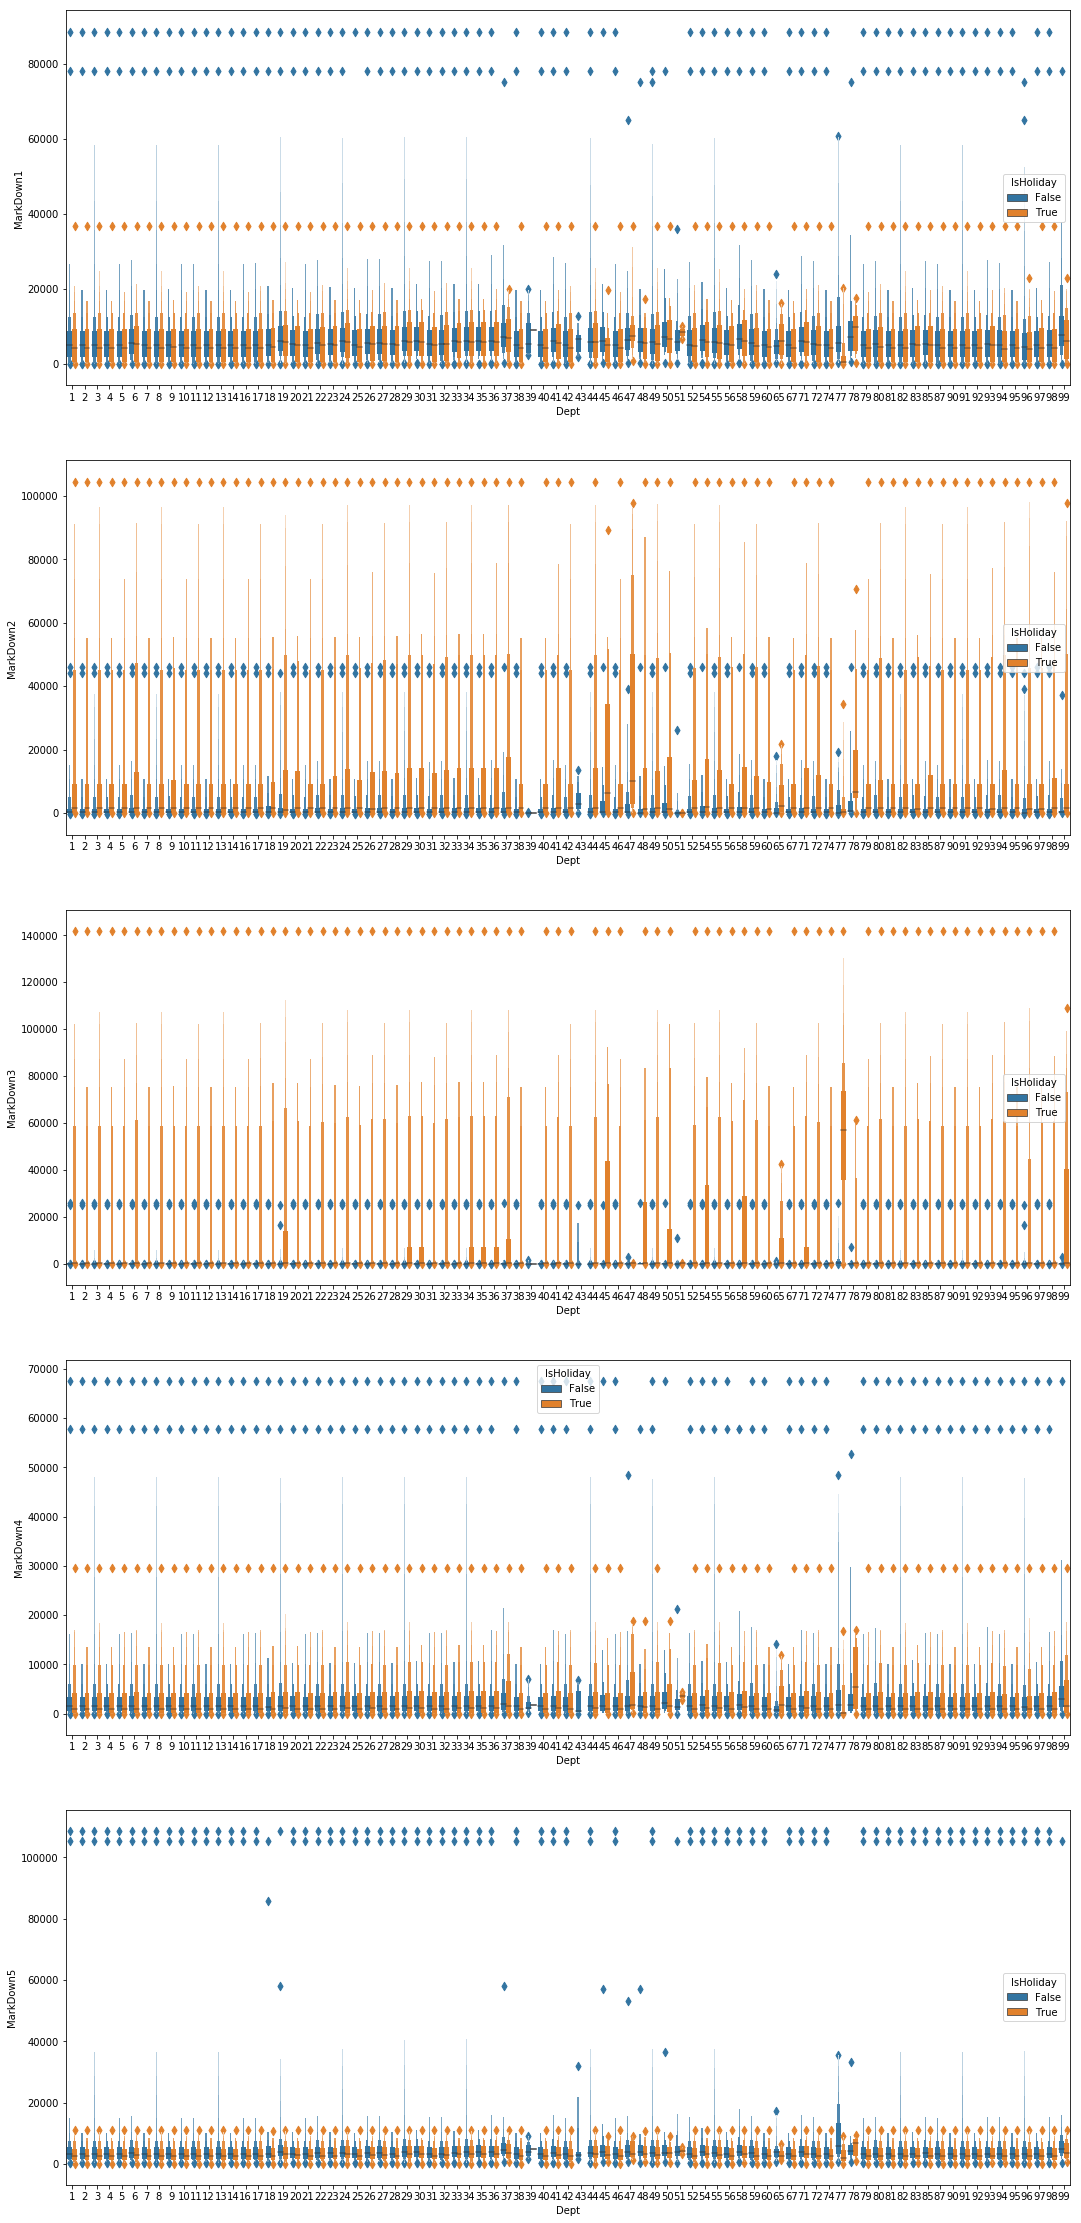

In [ ]:
fig,ax = plt.subplots(5,1,figsize=(18,40))
plt.subplots_adjust(wspace=0.3)
mrk = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
for i,axis in enumerate(ax.ravel()):
  if i==5 :
    fig.delaxes(axis)
    break
  sns.boxenplot(y=mrk[i],x='Dept',data=df_final,ax=axis,hue='IsHoliday');

For each department:
* Markdown2 is mostly varied on Holidays compared to non holiday values.
* Markdown5 values are bit lower on holidays compared to non holidays.
* Markdown1 and Markdown4 are similar and slightly higher on holidays.

Markdowns varying even from one department to another 

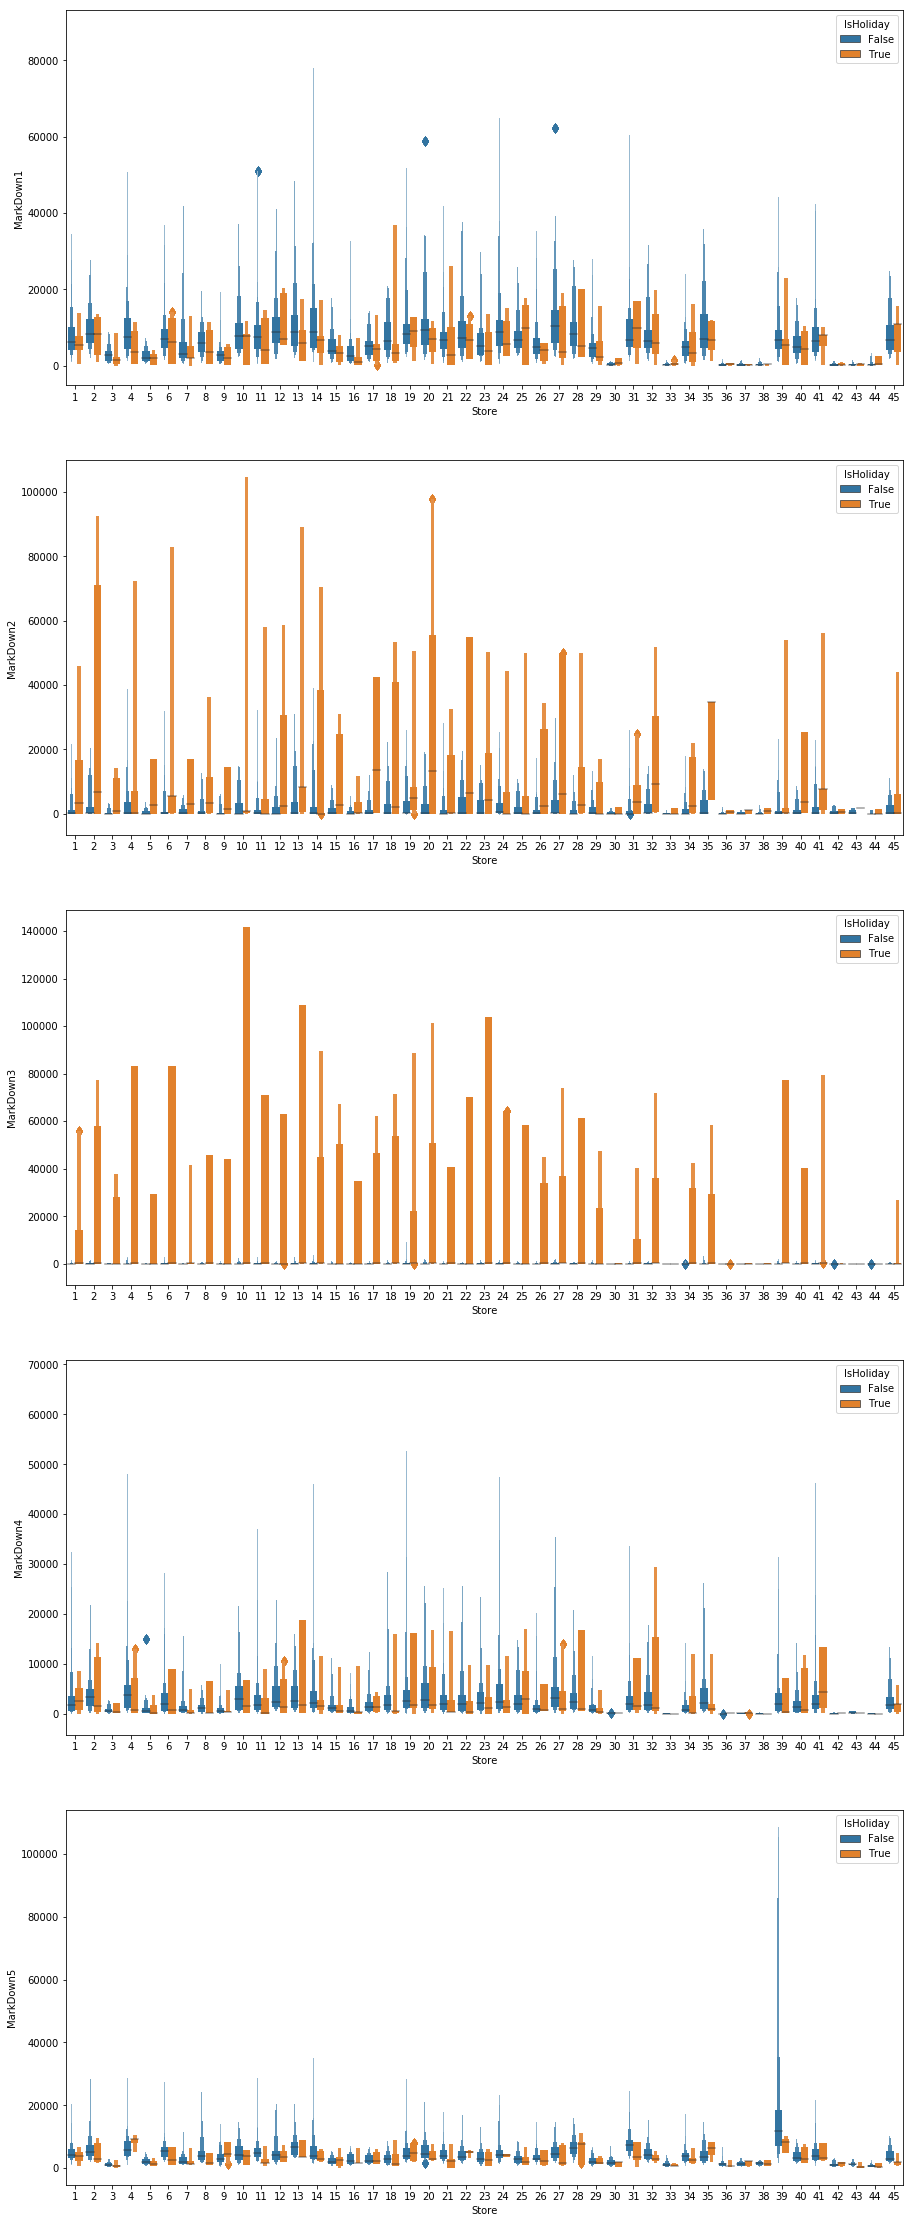

In [ ]:
fig,ax = plt.subplots(5,1,figsize=(15,40))
plt.subplots_adjust(wspace=0.3)
mrk = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
for i,axis in enumerate(ax.ravel()):
  if i==5 :
    fig.delaxes(axis)
    break
  sns.boxenplot(y=mrk[i],x='Store',data=df_final,ax=axis,hue='IsHoliday');

For each Store:
* Markdown2 and Markdown3 very similar and very high on holidays.
* Markdowns are varying even from one store to another 

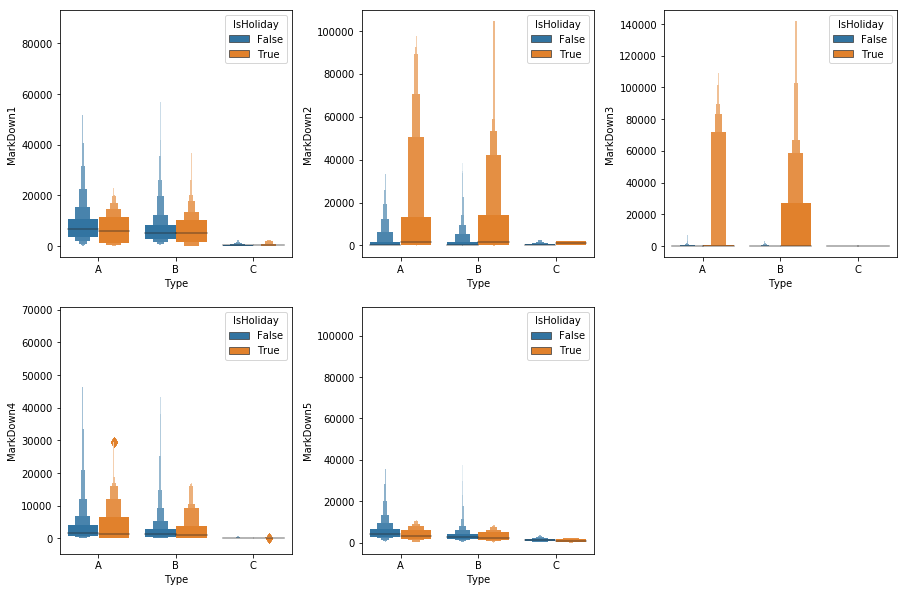

In [ ]:
fig,ax = plt.subplots(2,3,figsize=(15,10))
plt.subplots_adjust(wspace=0.3)
mrk = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
for i,axis in enumerate(ax.ravel()):
  if i==5 :
    fig.delaxes(axis)
    break
  sns.boxenplot(y=mrk[i],x='Type',data=df_final,ax=axis,hue='IsHoliday');

* Markdown2 and Markdown3 are having very high values during holidays for store types 'A' and 'B'
* Others are more or less similar during holidays.

## Time Features :

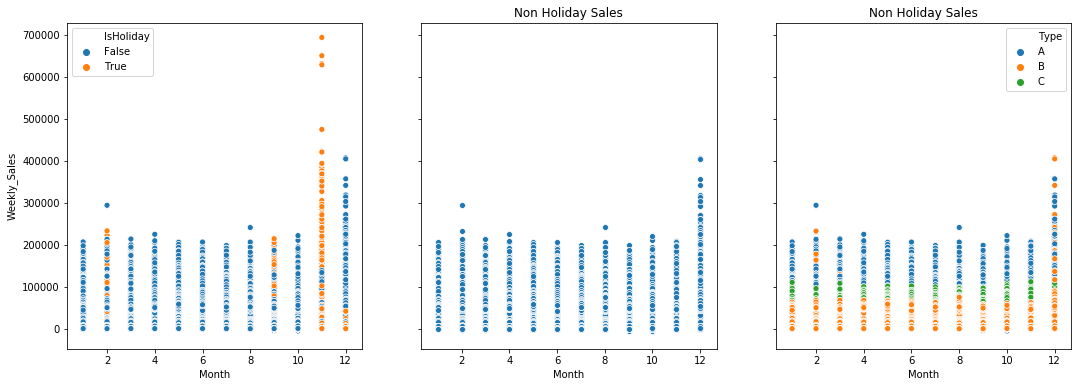

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(18,6),sharey=True,sharex=True)
sns.scatterplot(x=df_final.Date.dt.month,y='Weekly_Sales',data=df_final,hue='IsHoliday',ax=ax[0]);
ax[0].set_xlabel('Month');
sns.scatterplot(x=df_final[df_final.IsHoliday==False].Date.dt.month,y='Weekly_Sales',data=df_final,ax=ax[1]);
ax[1].set_xlabel('Month');
ax[1].set_title('Non Holiday Sales');
sns.scatterplot(x=df_final[df_final.IsHoliday==False].Date.dt.month,y='Weekly_Sales',data=df_final,hue='Type',ax=ax[2]);
ax[2].set_xlabel('Month');
ax[2].set_title('Non Holiday Sales');

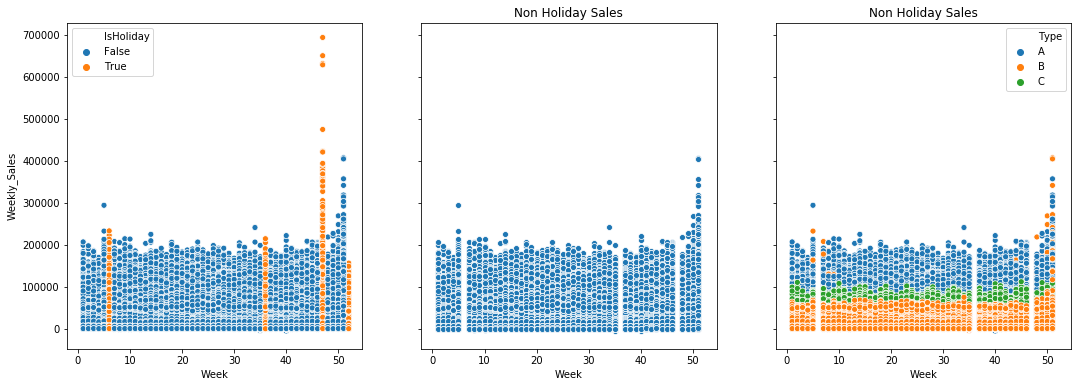

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(18,6),sharey=True,sharex=True)
sns.scatterplot(x=df_final.Date.dt.week,y='Weekly_Sales',data=df_final,hue='IsHoliday',ax=ax[0]);
ax[0].set_xlabel('Week');
sns.scatterplot(x=df_final[df_final.IsHoliday==False].Date.dt.week,y='Weekly_Sales',data=df_final,ax=ax[1]);
ax[1].set_xlabel('Week');
ax[1].set_title('Non Holiday Sales');
sns.scatterplot(x=df_final[df_final.IsHoliday==False].Date.dt.week,y='Weekly_Sales',data=df_final,hue='Type',ax=ax[2]);
ax[2].set_xlabel('Week');
ax[2].set_title('Non Holiday Sales');

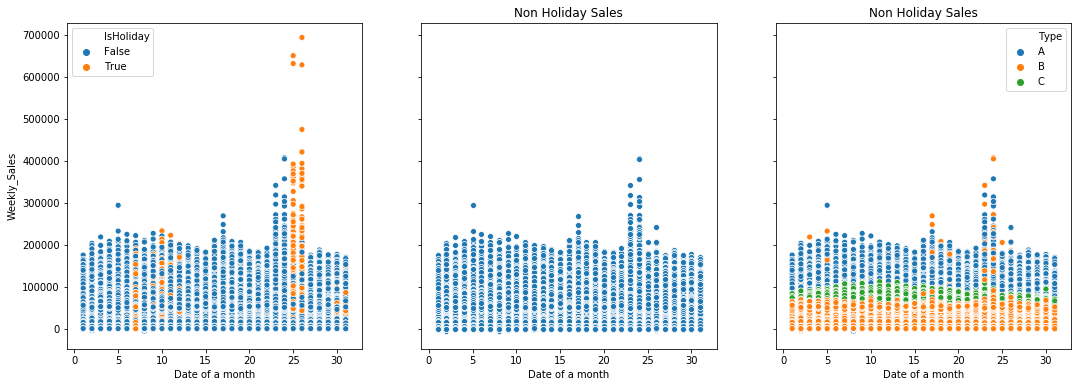

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(18,6),sharey=True,sharex=True)
sns.scatterplot(x=df_final.Date.dt.day,y='Weekly_Sales',data=df_final,hue='IsHoliday',ax=ax[0]);
ax[0].set_xlabel('Date of a month');
sns.scatterplot(x=df_final[df_final.IsHoliday==False].Date.dt.day,y='Weekly_Sales',data=df_final,ax=ax[1]);
ax[1].set_xlabel('Date of a month');
ax[1].set_title('Non Holiday Sales');
sns.scatterplot(x=df_final[df_final.IsHoliday==False].Date.dt.day,y='Weekly_Sales',data=df_final,hue='Type',ax=ax[2]);
ax[2].set_xlabel('Date of a month');
ax[2].set_title('Non Holiday Sales');

* The highest sales are recorded during November (Thanks giving) then during December (Christmas).
* At end of year before new year the (non-holiday) sales are as high as holiday sales.
* Other than sudden sales change during festive holidays, sales follow similar trend irrespective of day,week or month.

## Correlation between variables:

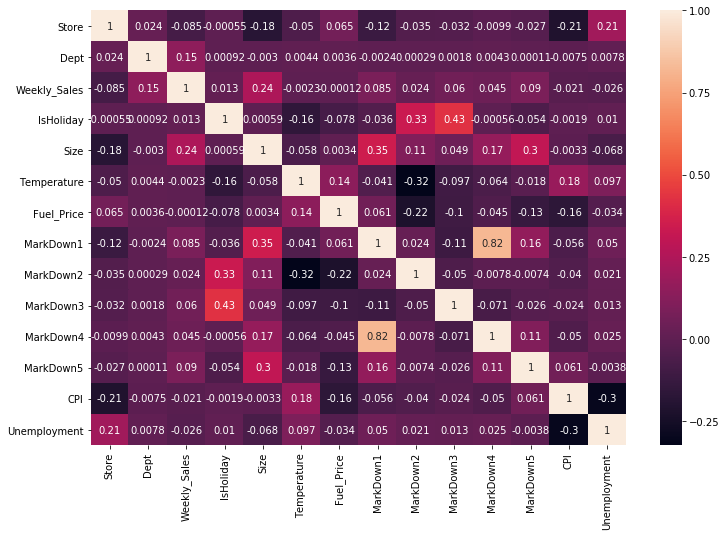

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(df_final.corr(),annot=True,);

* Markdown1 and Markdown4 are highly correlated, we can drop any one if necessary.

## New Features:

In [ ]:
temp = df_final.copy()
nn_hldy_sls_mean = temp[temp.IsHoliday==False].Weekly_Sales.mean()
## effect of holiday on store
hldy_store_sls = df_final[df_final.IsHoliday==True].groupby('Store').Weekly_Sales.mean()

nn_hldy_store_sls = df_final[df_final.IsHoliday==False].groupby('Store').Weekly_Sales.mean()

#hldy_effect_stores = (hldy_store_sls-nn_hldy_store_sls)/nn_hldy_store_sls
hldy_effect_stores = hldy_store_sls/nn_hldy_sls_mean #nn_hldy_store_sls
## effect of holiday on Dept
hldy_dept_sls = df_final[df_final.IsHoliday==True].groupby('Dept').Weekly_Sales.mean()

nn_hldy_dept_sls = df_final[df_final.IsHoliday==False].groupby('Dept').Weekly_Sales.mean()

#hldy_effect_dept = (hldy_dept_sls-nn_hldy_dept_sls)/nn_hldy_dept_sls

hldy_effect_dept = hldy_dept_sls/nn_hldy_sls_mean #_hldy_dept_sls
temp['sales'] = temp.Weekly_Sales/nn_hldy_sls_mean
temp['hldy_effect_stores'] = temp.Store.map(dict(zip(hldy_effect_stores.index,hldy_effect_stores.values)))
temp['hldy_effect_dept'] = temp.Store.map(dict(zip(hldy_effect_dept.index,hldy_effect_dept.values)))
## effect of holiday and size on Dept
hldy_size_A_sales = df_final[(df_final.Type=='A') & (df_final.IsHoliday==True)].groupby('Dept').Weekly_Sales.mean()
hldy_size_B_sales = df_final[(df_final.Type=='B') & (df_final.IsHoliday==True)].groupby('Dept').Weekly_Sales.mean()
hldy_size_C_sales = df_final[(df_final.Type=='C') & (df_final.IsHoliday==True)].groupby('Dept').Weekly_Sales.mean()

nn_hldy_size_A_sales = df_final[(df_final.Type=='A') & (df_final.IsHoliday==False)].groupby('Dept').Weekly_Sales.mean()
nn_hldy_size_B_sales = df_final[(df_final.Type=='B') & (df_final.IsHoliday==False)].groupby('Dept').Weekly_Sales.mean()
nn_hldy_size_C_sales = df_final[(df_final.Type=='C') & (df_final.IsHoliday==False)].groupby('Dept').Weekly_Sales.mean()


#hldy_nd_sze_A_effect_dept = (hldy_size_A_sales-nn_hldy_size_A_sales)/nn_hldy_size_A_sales
hldy_nd_sze_A_effect_dept = hldy_size_A_sales/nn_hldy_sls_mean #nn_hldy_size_A_sales
hldy_nd_sze_A_effect_dept = dict(zip(hldy_nd_sze_A_effect_dept.index,hldy_nd_sze_A_effect_dept.values))

#hldy_nd_sze_B_effect_dept = (hldy_size_B_sales-nn_hldy_size_B_sales)/nn_hldy_size_B_sales
hldy_nd_sze_B_effect_dept = hldy_size_B_sales/nn_hldy_sls_mean #nn_hldy_size_B_sales
hldy_nd_sze_B_effect_dept = dict(zip(hldy_nd_sze_B_effect_dept.index,hldy_nd_sze_B_effect_dept.values))

#hldy_nd_sze_C_effect_dept = (hldy_size_C_sales-nn_hldy_size_C_sales)/nn_hldy_size_C_sales
hldy_nd_sze_C_effect_dept = hldy_size_C_sales/nn_hldy_sls_mean #nn_hldy_size_C_sales
hldy_nd_sze_C_effect_dept = dict(zip(hldy_nd_sze_C_effect_dept.index,hldy_nd_sze_C_effect_dept.values))
lst=[]
for i,j in temp[['Type','Dept']].values:
  try :
    if i=='A':
      lst.append(hldy_nd_sze_A_effect_dept[j])
    if i=='B':
      lst.append(hldy_nd_sze_B_effect_dept[j])
    if i=='C':
      lst.append(hldy_nd_sze_C_effect_dept[j])
  except :
    lst.append(0)
temp['hldy_nd_sze_effect_dept'] = lst

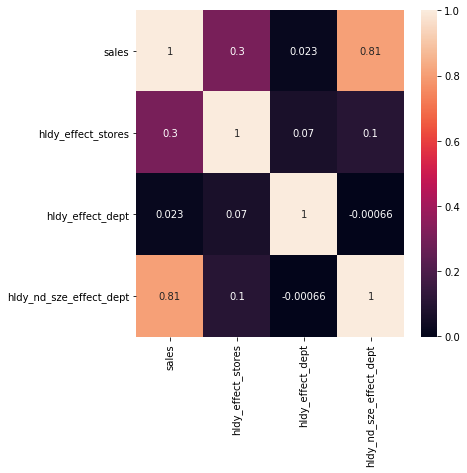

In [ ]:
plt.figure(figsize=(6,6))
sns.heatmap(temp[['sales','hldy_effect_stores', 'hldy_effect_dept', 'hldy_nd_sze_effect_dept']].corr(),annot=True);

* The feature 'hldy_nd_sze_effect_dept' is positively correlated to sales, might give some performance improvement, we can verify importance of newly added features after modelling.

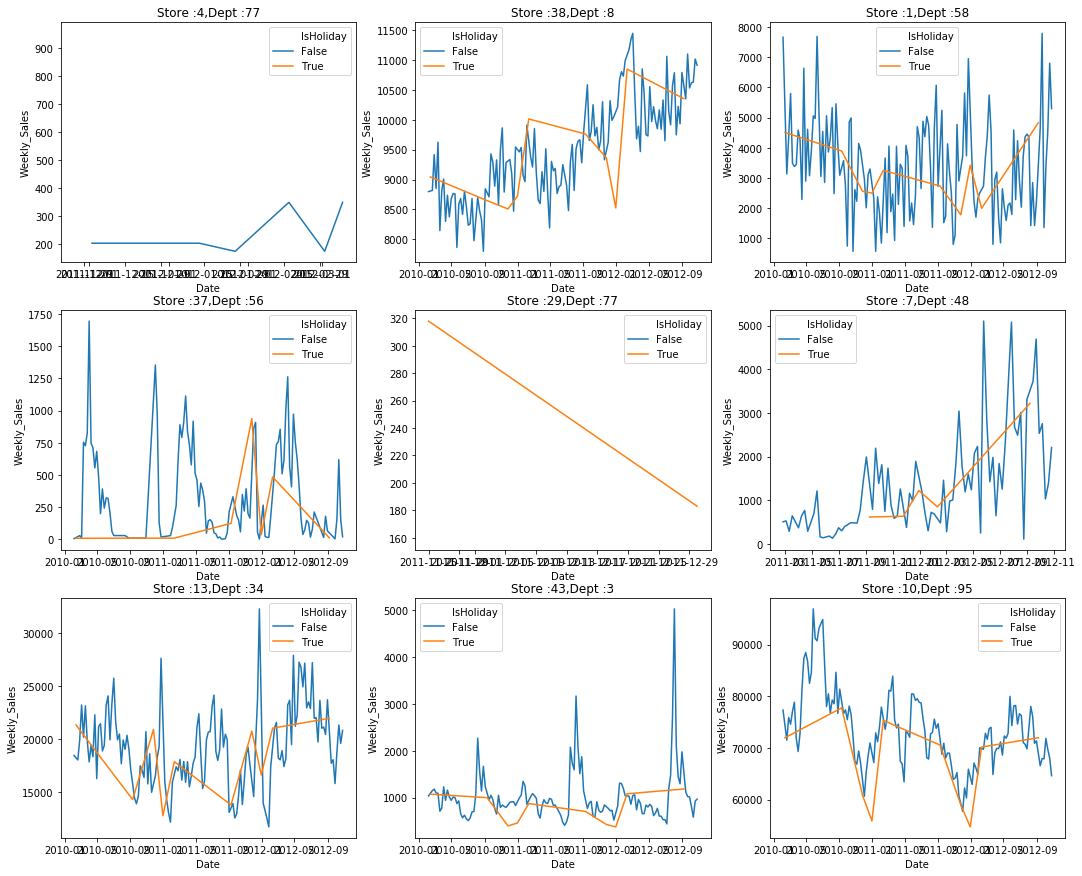

In [ ]:
fig,ax = plt.subplots(3,3,figsize=(18,15))
ax = ax.ravel()
for axis in ax:
  store = np.random.choice(df_final.Store.unique())
  dept = np.random.choice(df_final.Dept.unique())
  sns.lineplot(x='Date',y='Weekly_Sales',data = df_final[(df_final.Store==store) & (df_final.Dept==dept)],
               hue='IsHoliday',ax=axis);
  axis.set_title('Store :%d,Dept :%d'%(store,dept))

* We can observe there aren't much datails of sales history for some stores and departments.
* Every department isn't present in every store.

# Modelling

## Train & Test Splitting

In [ ]:
train_unsplt=df_final[df_final.Date >= df_final.Date.min()+pd.DateOffset(months=12)]
train,test = train_test_split(train_unsplt,test_size=0.2,random_state=5)
train,cv = train_test_split(train,test_size=0.2,random_state=5)

In [ ]:
train.shape,cv.shape,test.shape

((170412, 16), (42604, 16), (53254, 16))

In [ ]:
dct={}
for store,dept,year,week,sales in zip(df_final.Store,df_final.Dept,df_final.Date.dt.year,df_final.Date.dt.week,df_final.Weekly_Sales):
  dct['_'.join(list(map(str,[store,dept,year,week])))] = sales
lstyr=[]
for store,dept,year,week in zip(test_final.Store,test_final.Dept,test_final.Date.dt.year,test_final.Date.dt.week):
  try:
    lstyr.append(dct['_'.join(list(map(str,[store,dept,year-1,week])))])
  except:
    lstyr.append(0)
## effect of holiday on store

nn_hldy_sls_mean = train[train.IsHoliday==False].Weekly_Sales.mean()

hldy_store_sls = train[train.IsHoliday==True].groupby('Store').Weekly_Sales.mean()

nn_hldy_store_sls = train[train.IsHoliday==False].groupby('Store').Weekly_Sales.mean()

#hldy_effect_stores = (hldy_store_sls-nn_hldy_store_sls)/nn_hldy_store_sls
hldy_effect_stores = hldy_store_sls/nn_hldy_sls_mean #nn_hldy_store_sls
## effect of holiday on Dept

hldy_dept_sls = train[train.IsHoliday==True].groupby('Dept').Weekly_Sales.mean()

nn_hldy_dept_sls = train[train.IsHoliday==False].groupby('Dept').Weekly_Sales.mean()

#hldy_effect_dept = (hldy_dept_sls-nn_hldy_dept_sls)/nn_hldy_dept_sls

hldy_effect_dept = hldy_dept_sls/nn_hldy_sls_mean #_hldy_dept_sls
## effect of holiday and size on Dept
hldy_size_A_sales = train[(train.Type=='A') & (train.IsHoliday==True)].groupby('Dept').Weekly_Sales.mean()
hldy_size_B_sales = train[(train.Type=='B') & (train.IsHoliday==True)].groupby('Dept').Weekly_Sales.mean()
hldy_size_C_sales = train[(train.Type=='C') & (train.IsHoliday==True)].groupby('Dept').Weekly_Sales.mean()

nn_hldy_size_A_sales = train[(train.Type=='A') & (train.IsHoliday==False)].groupby('Dept').Weekly_Sales.mean()
nn_hldy_size_B_sales = train[(train.Type=='B') & (train.IsHoliday==False)].groupby('Dept').Weekly_Sales.mean()
nn_hldy_size_C_sales = train[(train.Type=='C') & (train.IsHoliday==False)].groupby('Dept').Weekly_Sales.mean()


#hldy_nd_sze_A_effect_dept = (hldy_size_A_sales-nn_hldy_size_A_sales)/nn_hldy_size_A_sales
hldy_nd_sze_A_effect_dept = hldy_size_A_sales/nn_hldy_sls_mean #nn_hldy_size_A_sales
hldy_nd_sze_A_effect_dept = dict(zip(hldy_nd_sze_A_effect_dept.index,hldy_nd_sze_A_effect_dept.values))

#hldy_nd_sze_B_effect_dept = (hldy_size_B_sales-nn_hldy_size_B_sales)/nn_hldy_size_B_sales
hldy_nd_sze_B_effect_dept = hldy_size_B_sales/nn_hldy_sls_mean #nn_hldy_size_B_sales
hldy_nd_sze_B_effect_dept = dict(zip(hldy_nd_sze_B_effect_dept.index,hldy_nd_sze_B_effect_dept.values))

#hldy_nd_sze_C_effect_dept = (hldy_size_C_sales-nn_hldy_size_C_sales)/nn_hldy_size_C_sales
hldy_nd_sze_C_effect_dept = hldy_size_C_sales/nn_hldy_sls_mean #nn_hldy_size_C_sales
hldy_nd_sze_C_effect_dept = dict(zip(hldy_nd_sze_C_effect_dept.index,hldy_nd_sze_C_effect_dept.values))

def hldy_sze_effct(temp):
  lst=[]
  for i,j in temp[['Type','Dept']].values:
    try :
      if i=='A':
        lst.append(hldy_nd_sze_A_effect_dept[j])
      if i=='B':
        lst.append(hldy_nd_sze_B_effect_dept[j])
      if i=='C':
        lst.append(hldy_nd_sze_C_effect_dept[j])
    except :
      lst.append(1)
  return lst  
mrk1 = train.groupby(['Type','IsHoliday']).MarkDown1.mean().unstack()
mrk2 = train.groupby(['Type','IsHoliday']).MarkDown2.mean().unstack()
mrk3 = train.groupby(['Type','IsHoliday']).MarkDown3.mean().unstack()
mrk4 = train.groupby(['Type','IsHoliday']).MarkDown4.mean().unstack()
mrk5 = train.groupby(['Type','IsHoliday']).MarkDown5.mean().unstack()

def fillna(data,col,mrk):
  lst=[]
  for tpe,hldy,mark in data[['Type','IsHoliday',col]].values:
      if mark != mark : lst.append(mrk.loc[tpe,hldy])
      else : lst.append(mark)
  return lst

def last_year_sales(data):
  lstyr=[]
  for store,dept,year,week in zip(data.Store,data.Dept,data.Date.dt.year,data.Date.dt.week):
    try:
      lstyr.append(dct['_'.join(list(map(str,[store,dept,year-1,week])))])
    except:
      lstyr.append(0)
  return np.array(lstyr)/nn_hldy_sls_mean

def preprocess(data,tst=False):
  data = data.copy()
  
  data.loc[(data.Type!='C') & (data.Size<50000), ['Type']] = 'C'
  
  if not tst :  data['sales'] = data.Weekly_Sales/nn_hldy_sls_mean
    
  if tst :
    data['CPI'].fillna(data.CPI.mean(),inplace=True)
    data['Unemployment'].fillna(data.Unemployment.mean(),inplace=True)
    
  data['week'] = data.Date.dt.week
  
  data['month'] = data.Date.dt.month
  
  data['hldy_effect_stores'] = data.Store.map(dict(zip(hldy_effect_stores.index,hldy_effect_stores.values)))

  data['hldy_effect_dept'] = data.Store.map(dict(zip(hldy_effect_dept.index,hldy_effect_dept.values)))
  
  data['hldy_nd_sze_effect_dept'] = hldy_sze_effct(data)
  
  data['last_year_sales'] = last_year_sales(data)
  
  data.fillna(1,inplace=True)
  
  data = pd.concat([data,pd.get_dummies(data.Store,prefix='Store'),
          pd.get_dummies(data.Dept,prefix='Dept'),
          pd.get_dummies(data.IsHoliday,prefix='IsHoliday'),
          pd.get_dummies(data.Type,prefix='Type'),
          pd.get_dummies(data.week,prefix='week'),
          pd.get_dummies(data.month,prefix='month')],axis=1)
  
  #data['MarkDown1'] = fillna(data,'MarkDown1',mrk1)
  #data['MarkDown2'] = fillna(data,'MarkDown2',mrk2)
  #data['MarkDown3'] = fillna(data,'MarkDown3',mrk3)
  data['MarkDown4'] = fillna(data,'MarkDown4',mrk4)
  #data['MarkDown5'] = fillna(data,'MarkDown5',mrk5)
  
  data.drop(['Date','Store','Dept','IsHoliday','Type','week','month','MarkDown1','MarkDown2','MarkDown3','MarkDown5'],axis=1,inplace=True)
  
  if not tst: data = data.sample(frac=1).reset_index(drop=True)
  
  return data

In [ ]:
train_unsplt_prcssd = preprocess(train_unsplt)
train_prcssd = preprocess(train)
cv_prcssd = preprocess(cv).align(train_prcssd,axis=1,join='right')[0].fillna(0)
test_prcssd = preprocess(test).align(train_prcssd,axis=1,join='right')[0].fillna(0)
final_test_procssd = preprocess(test_final,tst=True).align(train_prcssd,axis=1,join='right')[0].fillna(0)

In [ ]:
list(train_prcssd.columns)

In [ ]:
train_prcssd.shape,cv_prcssd.shape,test_prcssd.shape,final_test_procssd.shape

((170412, 207), (42604, 207), (53254, 207), (115064, 207))

In [ ]:
x_train_ttl = train_unsplt_prcssd.drop(['Weekly_Sales','sales'],axis=1)
x_train = train_prcssd.drop(['Weekly_Sales','sales'],axis=1)
x_cv = cv_prcssd.drop(['Weekly_Sales','sales'],axis=1)
x_test = test_prcssd.drop(['Weekly_Sales','sales'],axis=1)
x_final_test = final_test_procssd.drop(['Weekly_Sales','sales'],axis=1)

y_train_ttl = train_unsplt_prcssd.sales.values
y_train = train_prcssd.sales.values
y_cv = cv_prcssd.sales.values
y_test = test_prcssd.sales.values
x_train.shape,x_cv.shape,x_test.shape,x_final_test.shape,y_train.shape,y_cv.shape,y_test.shape

((170412, 205),
 (42604, 205),
 (53254, 205),
 (115064, 205),
 (170412,),
 (42604,),
 (53254,))

In [ ]:
train_unsplt_w8s = train_unsplt_prcssd.IsHoliday_True.map({0:1,1:5})
train_w8s = x_train.IsHoliday_True.map({0:1,1:5})
cv_w8s = x_cv.IsHoliday_True.map({0:1,1:5})
test_w8s = x_test.IsHoliday_True.map({0:1,1:5})
test_final_w8s = x_final_test.IsHoliday_True.map({0:1,1:5})

## Regression Modelling

In [ ]:
def performance(lr,model='',nrm=0,dl=0):
  print('Performance of %s Model\n'%(model))
  print('*'*60,'\n')
  if nrm : trn,cv,tst = MinMaxScaler().fit_transform(x_train),MinMaxScaler().fit_transform(x_cv),MinMaxScaler().fit_transform(x_test)
  if not nrm : trn,cv,tst = x_train,x_cv,x_test
  #ytrn,ycv,ytst =  y_train, y_cv, y_test
  #if not dl :yptr,ypcv,yp = lr.predict(trn), lr.predict(cv), lr.predict(tst)'''
  ytrn,ycv,ytst =  y_train*nn_hldy_sls_mean, y_cv*nn_hldy_sls_mean, y_test*nn_hldy_sls_mean
  if not dl :yptr,ypcv,yp = lr.predict(trn)*nn_hldy_sls_mean, lr.predict(cv)*nn_hldy_sls_mean, lr.predict(tst)*nn_hldy_sls_mean
  if dl: yptr,ypcv,yp = lr.predict(trn).ravel()*nn_hldy_sls_mean, lr.predict(cv).ravel()*nn_hldy_sls_mean, lr.predict(tst).ravel()*nn_hldy_sls_mean
  r2_trn,r2_cv,r2_tst = r2_score(ytrn,yptr),r2_score(ycv,ypcv),r2_score(ytst,yp)
  rmse_trn,rmse_cv,rmse_tst = wmae(ytrn,yptr,train_w8s,mltply=0),wmae(ycv,ypcv,cv_w8s,mltply=0),wmae(ytst,yp,test_w8s,mltply=0)
  table = PrettyTable()
  table.field_names = ['Data','WMAE','R^2']
  for i,j,k in zip(['Train','CV','Test'],[rmse_trn,rmse_cv,rmse_tst],[r2_trn,r2_cv,r2_tst]):
    table.add_row([i,j,k])
    
  print(table)
  print('*'*90,'\n')
  fig,ax=plt.subplots(2,2,figsize=(15,10));
  #plt.subplots_adjust(wspace=0.2)
  i,j=0,0
  sns.regplot(ytst,yp,ax=ax[i,j],color='m');
  #print(ax.shape,ax)
  ax[i,j].set_xlabel('True Values')
  ax[i,j].set_ylabel("Predicted Values")
  ax[i,j].set_title('Prediction Plot')
  
  i,j =0,1
  #print(ax[i,j])
  sns.scatterplot(x_test.reset_index().index,yp[np.argsort(ytst)],label='Predicted values',ax=ax[i,j]);
  sns.scatterplot(x_test.reset_index().index,np.sort(ytst),label='True Values',ax=ax[i,j]);
  
  
  i,j=1,0
  pc = [i*5 for i in range(21)]
  abs_err = abs(ytst-yp)
  prcntl = np.percentile(abs_err,pc)
  sns.scatterplot(pc,prcntl,color='r',ax=ax[i,j])
  #ax[i,j].scatter([95+i/10 for i in range(6)],np.percentile(abs_err,[95+i/10 for i in range(6)]),color='b')
  ax[i,j].plot(pc,prcntl,);
  ax[i,j].set_xlabel('Percentile of Absolute errors')
  ax[i,j].set_xlabel('Absolute errors')
  ax[i,j].set_title('Percentiles of Absolute errors')
  
  plt.sca(ax[i,j])
  plt.xticks(pc)
  plt.setp(ax[i,j].get_xticklabels(),rotation=90);
  i,j = 1,1
  sns.kdeplot(ytst,ax=ax[i,j],label='True values')
  sns.kdeplot(yp,ax=ax[i,j],label='Predicted values')
  ax[i,j].set_title('Distribution of true and predicted sales')
  #ax[i,j].set_ylim(0,lm);
  
  return r2_trn,r2_tst,rmse_trn,rmse_tst
def feature_imp(cl):
  importances = cl.feature_importances_
  indices = np.argsort(importances)[::-1]
  names = [x_train.columns[i] for i in indices]
  plt.figure(figsize=(10,7))
  plt.barh(range(30,0,-1),importances[indices][:30],height=0.8,tick_label=names[:30])
  plt.show()
def wmae(ytrue,ypred,w8s,mltply=1):
  if type(ypred) == list : ypred = np.array(ypred)
  if mltply : ytrue,ypred = ytrue*nn_hldy_sls_mean,ypred*nn_hldy_sls_mean
  return np.average(np.abs(ypred - ytrue),weights=w8s)

## Mean Prediction (Dump Model):

In [ ]:
r2_trn,r2_tst,rmse_trn,rmse_tst = np.zeros((4,10))

In [ ]:
mn = y_train.mean()
mn

1.0053333201008232

In [ ]:
ytrn_p = [mn for i in range(len(y_train))]
y_tst_p = [mn for i in range(len(y_test))]

In [ ]:
i=0
r2_trn[i],r2_tst[i],rmse_trn[i],rmse_tst[i] = r2_score(y_train*nn_hldy_sls_mean,ytrn_p),r2_score(y_test*nn_hldy_sls_mean,y_tst_p),wmae(y_train,ytrn_p,train_w8s),wmae(y_test,y_tst_p,test_w8s)

In [ ]:
print('WMAE for mean prediction on Train data :',wmae(y_train*nn_hldy_sls_mean,[mn*nn_hldy_sls_mean for i in range(len(y_train))],train_w8s,mltply=0))
print('WMAE for mean prediction on CV data :',wmae(y_cv*nn_hldy_sls_mean,[mn*nn_hldy_sls_mean for i in range(len(y_cv))],cv_w8s,mltply=0))
print('WMAE for mean prediction on Test data :',wmae(y_test*nn_hldy_sls_mean,[mn*nn_hldy_sls_mean for i in range(len(y_test))],test_w8s,mltply=0))

WMAE for mean prediction on Train data : 15412.750198100299
WMAE for mean prediction on CV data : 14989.623360892587
WMAE for mean prediction on Test data : 15443.284964553373


## Linear Regression:

In [ ]:
lr = LinearRegression(n_jobs=-1).fit(x_train,y_train,sample_weight=train_w8s)

Performance of Linear Regression Model

************************************************************ 

+-------+--------------------+--------------------+
|  Data |        WMAE        |        R^2         |
+-------+--------------------+--------------------+
| Train | 1968.8345568343007 | 0.972204125125986  |
|   CV  | 1948.487598550828  | 0.9711813346197405 |
|  Test | 1971.636621004865  | 0.9719309249835074 |
+-------+--------------------+--------------------+
****************************************************************************************** 



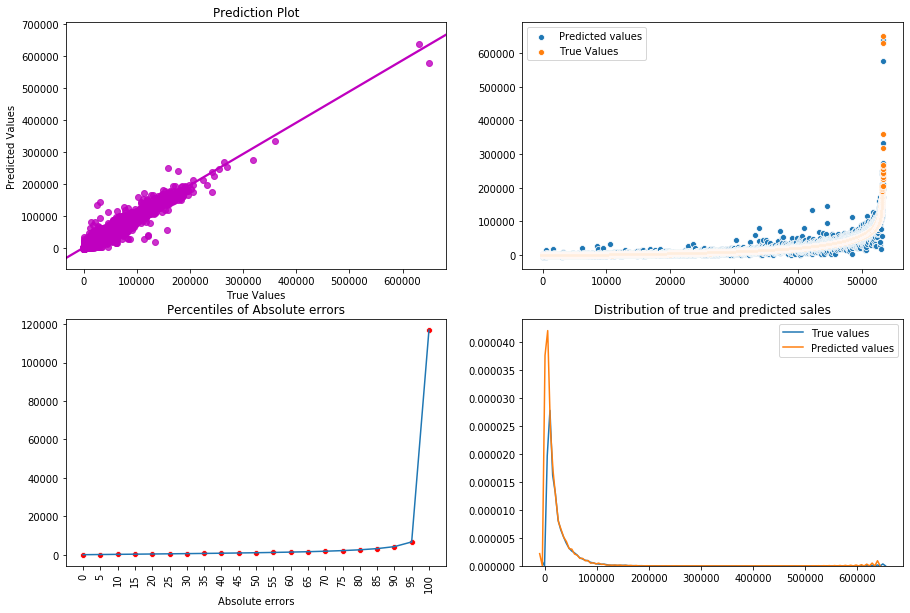

In [ ]:
i=1
r2_trn[i],r2_tst[i],rmse_trn[i],rmse_tst[i] = performance(lr,model='Linear Regression')

## Random Forest Regressor:

In [ ]:
chk=np.inf
params={}
for n_estimators in [50,100]:
  for max_depth in [3,7,15,None]:
    for min_samples_split in [2,5,15]:
      for min_samples_leaf in [5,10,50,100]:
        clf = RandomForestRegressor(n_estimators=n_estimators,min_samples_leaf=min_samples_leaf,n_jobs=-1,
                                    min_samples_split=min_samples_split,max_depth=max_depth,random_state=5)
        clf.fit(x_train,y_train,sample_weight=train_w8s)
        err = wmae(y_cv,clf.predict(x_cv),cv_w8s,mltply=1)
        #print(err)
        if err <chk:
          params = {'n_estimators':n_estimators,'min_samples_leaf':min_samples_leaf,'min_samples_split':min_samples_split,'max_depth':max_depth}
          print(params)
          print('R^2 score on Train is %f and on Validation is %f'%(clf.score(x_train,y_train),clf.score(x_cv,y_cv)))
          print('WMAE on Train is %f and on Validation is %f'%(wmae(y_train,clf.predict(x_train),train_w8s,mltply=1),wmae(y_cv,clf.predict(x_cv),cv_w8s,mltply=1)))
          print('='*80)
          chk=err

In [ ]:
params

{'max_depth': None,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 100}

In [ ]:
clf = RandomForestRegressor(n_estimators=100, min_samples_leaf=5 ,n_jobs=-1,
                                    min_samples_split=2, max_depth=None, random_state=5)
clf.fit(x_train,y_train,sample_weight=train_w8s)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=5, verbose=0,
                      warm_start=False)

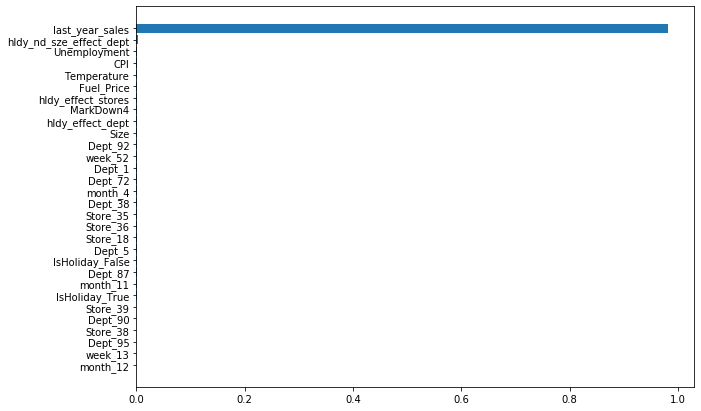

In [ ]:
feature_imp(clf)

Performance of Random Forest Regressor Model

************************************************************ 

+-------+--------------------+--------------------+
|  Data |        WMAE        |        R^2         |
+-------+--------------------+--------------------+
| Train | 1003.0302335075008 | 0.9893758301795809 |
|   CV  | 1540.8489122654346 | 0.9784121388241592 |
|  Test | 1580.326257308639  | 0.9726787739379096 |
+-------+--------------------+--------------------+
****************************************************************************************** 



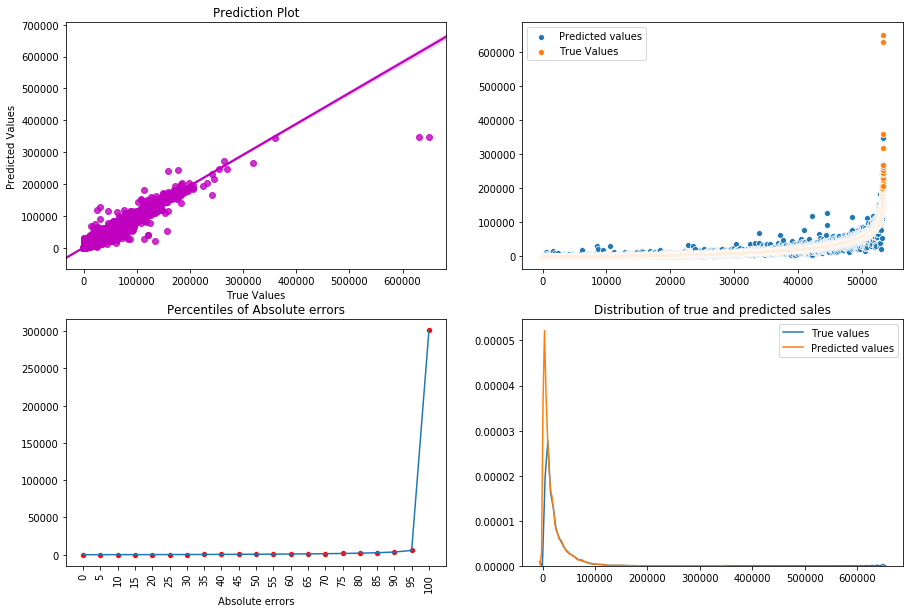

In [ ]:
i=2
r2_trn[i],r2_tst[i],rmse_trn[i],rmse_tst[i] = performance(clf,model='Random Forest Regressor')

## XGBRegressor :

In [ ]:
chk=np.inf
trn_err=[]
tst_err=[]
params={}
for n_estimators in [100,250,500]:
  for max_depth in [2,3,5,7,15]:
    for learning_rate in [0.08,0.1,0.12]:
      for reg_alpha in [0.0,0.005,0.001]:
        for min_child_weight in [1,3,5]:
          clf = XGBRegressor( n_estimators=n_estimators,learning_rate=learning_rate,reg_alpha=reg_alpha,n_jobs=8,tree_method='gpu_hist',
                                    objective='reg:squarederror',max_depth=max_depth,random_state=5,min_child_weight=min_child_weight)
          clf.fit(x_train,y_train,sample_weight=train_w8s)
          err = wmae(y_cv,clf.predict(x_cv),cv_w8s,mltply=1)
          err_trn = wmae(y_train,clf.predict(x_train),train_w8s,mltply=1)
          trn_err.append(err_trn)
          tst_err.append(err)
          if err <chk:
            params = {'n_estimators':n_estimators,'learning_rate':learning_rate,'reg_alpha':reg_alpha,'max_depth':max_depth,'min_child_weight':min_child_weight}
            print(params)
            print('R^2 score on Train is %f and on Validation is %f'%(clf.score(x_train1,y_train),clf.score(x_cv1,y_cv)))
            print('WMAE on Train is %f and on Validation is %f'%(err_trn,err))
            print('='*80)
            chk=err

In [ ]:
prms_xgb

{'n_estimators': 500,
 'learning_rate': 0.12,
 'reg_alpha': 0.001,
 'max_depth': 15,
 'min_child_weight': 5}

In [ ]:
clf_xgb = XGBRegressor( n_estimators=500,learning_rate=0.12,reg_alpha=0.001,n_jobs=-1,nthread=-1,tree_method='gpu_hist',
                                    objective='reg:squarederror',max_depth=15,random_state=5,min_child_weight=5)
clf_xgb.fit(x_train,y_train,sample_weight=train_w8s)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.12, max_delta_step=0,
             max_depth=15, min_child_weight=5, missing=None, n_estimators=500,
             n_jobs=-1, nthread=-1, objective='reg:squarederror',
             random_state=5, reg_alpha=0.001, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

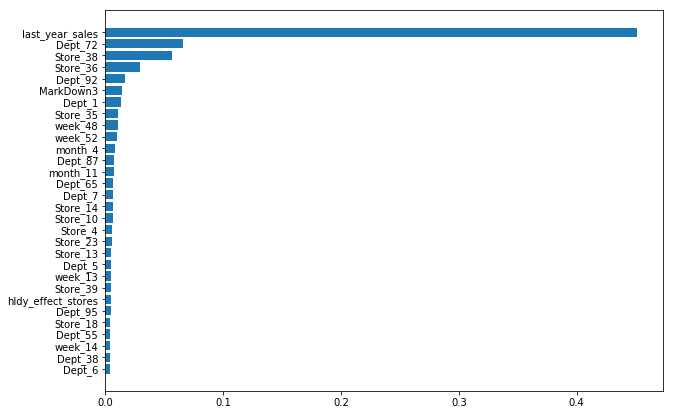

In [ ]:
feature_imp(clf_xgb)

Performance of XGBRegressor Model

************************************************************ 

+-------+--------------------+--------------------+
|  Data |        WMAE        |        R^2         |
+-------+--------------------+--------------------+
| Train | 256.3263136642528  | 0.9995959222479827 |
|   CV  | 1304.6658368024614 | 0.985183800331339  |
|  Test | 1391.2774720353052 | 0.975087266611886  |
+-------+--------------------+--------------------+
****************************************************************************************** 



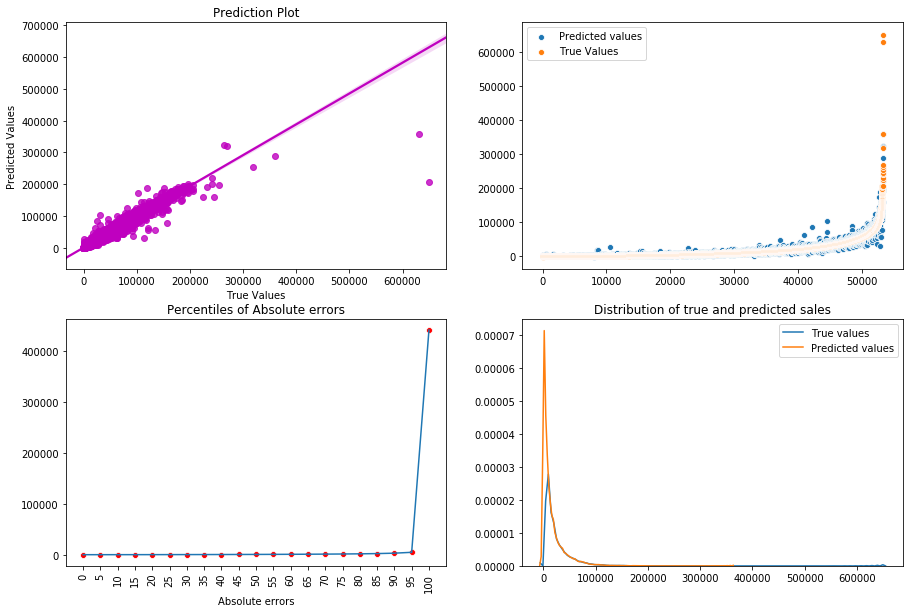

In [ ]:
i=3
r2_trn[i],r2_tst[i],rmse_trn[i],rmse_tst[i] = performance(clf_xgb,model='XGBRegressor')

## Neural Network for Regression:

In [ ]:
x_train_nrm = MinMaxScaler().fit_transform(x_train)
x_cv_nrm = MinMaxScaler().fit_transform(x_cv)
x_test_nrm = MinMaxScaler().fit_transform(x_test)

In [ ]:
def r2score(y_true, y_pred):
    u = K.sum(K.square(y_true - y_pred))
    v = K.sum(K.square(y_true - K.mean(y_true)))
    return K.ones_like(v) - (u / v)

In [ ]:
import tensorflow as tf
import keras.backend as K
from keras.layers import Dense,Input
from keras.models import Sequential

Using TensorFlow backend.


In [ ]:
model = Sequential()
model.add(Dense(256,activation='relu',input_dim=x_train_nrm.shape[1]))
model.add(Dense(512,activation='relu'))
model.add(Dense(1024,activation='relu'))
model.add(Dense(1024,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,kernel_regularizer='l2'))

In [ ]:
model.compile('adam',loss='mse',metrics=['mse',r2score])

In [ ]:
model.fit(x_train_nrm,y_train,batch_size=256,epochs=20,validation_data=(x_cv_nrm,y_cv))

In [ ]:
#model.save('model1.h5')
model = tf.keras.models.load_model('model1.h5',custom_objects={'r2score':r2score})

Performance of Neural Network Model

************************************************************ 

+-------+--------------------+--------------------+
|  Data |        WMAE        |        R^2         |
+-------+--------------------+--------------------+
| Train | 1047.0713176733836 | 0.9930774573391224 |
|   CV  | 1745.431772295825  | 0.9731852535124732 |
|  Test | 1838.5559838107852 | 0.9684778390365033 |
+-------+--------------------+--------------------+
****************************************************************************************** 



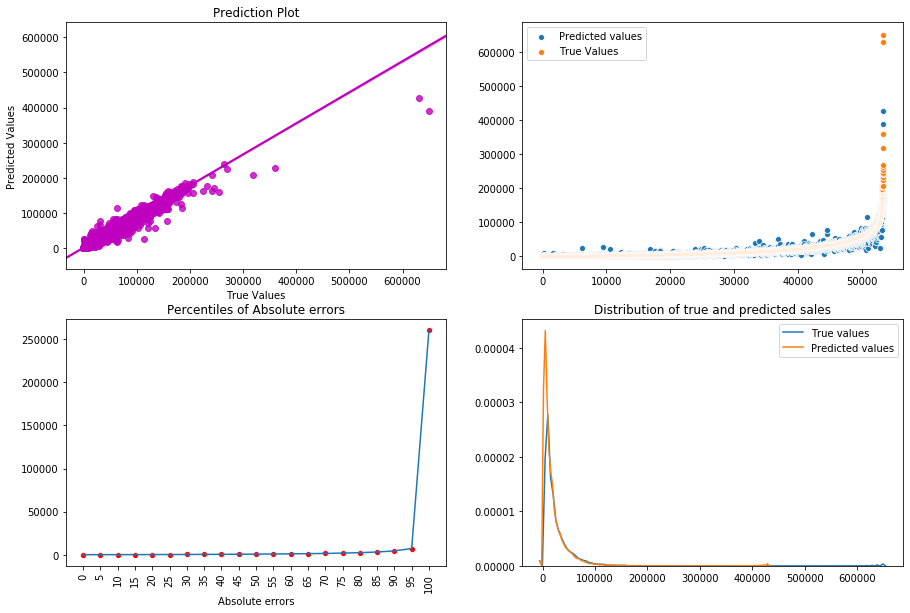

In [ ]:
i=4
r2_trn[i],r2_tst[i],rmse_trn[i],rmse_tst[i] = performance(model,model='Neural Network',nrm=1,dl=1)

## Averaging all models :(Average Ensemble)

In [ ]:
class ensmble:
  def __init__(self,mdls):
    self.models = mdls
    
  def predict(self,x):
    yp = np.zeros(len(x))
    for mdl in self.models:
      if isinstance(mdl,tf.python.keras.engine.sequential.Sequential):
        yp += mdl.predict(MinMaxScaler().fit_transform(x)).ravel()
      else : yp += mdl.predict(x)
    return yp/len(self.models)

In [ ]:
##Training all models on Total training data
lr = LinearRegression(n_jobs=-1).fit(x_train,y_train,sample_weight=train_w8s)

clf = RandomForestRegressor(n_estimators=100, min_samples_leaf=5 ,n_jobs=-1,
                                    min_samples_split=2, max_depth=None, random_state=5).fit(x_train,y_train,sample_weight=train_w8s)

clf_xgb = XGBRegressor( n_estimators=500,learning_rate=0.12,reg_alpha=0.001,n_jobs=-1,nthread=-1,tree_method='gpu_hist',
                                    objective='reg:squarederror',max_depth=15,random_state=5,min_child_weight=5).fit(x_train,y_train,sample_weight=train_w8s)

In [ ]:
ensmbl = ensmble([clf,clf_xgb,model])

Performance of Ensemble Model Model

************************************************************ 

+-------+--------------------+--------------------+
|  Data |        WMAE        |        R^2         |
+-------+--------------------+--------------------+
| Train | 646.1563283672443  | 0.9967904587861978 |
|   CV  | 1285.8118806702385 | 0.9854106084092557 |
|  Test | 1348.454383321039  | 0.9785994652022654 |
+-------+--------------------+--------------------+
****************************************************************************************** 



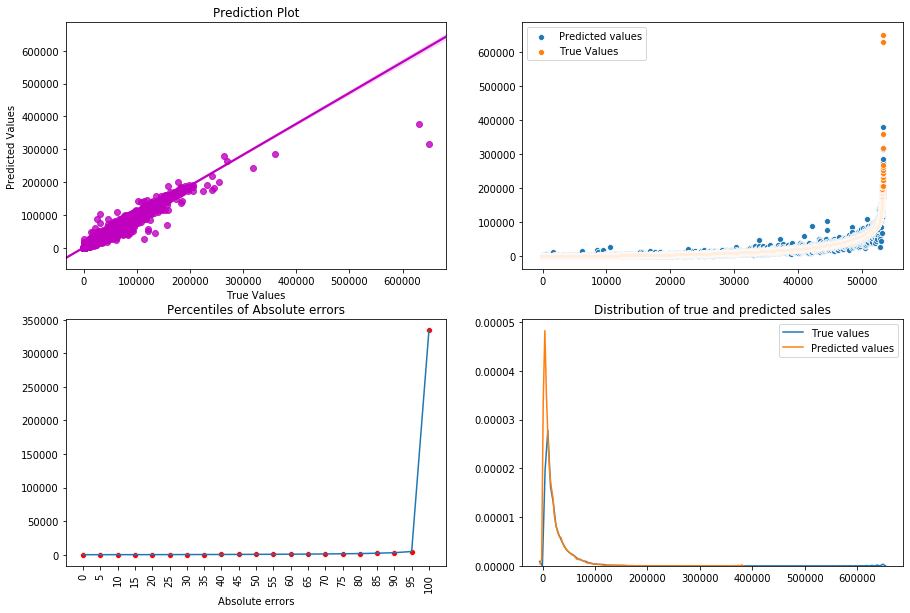

In [ ]:
i=5
r2_trn[i],r2_tst[i],rmse_trn[i],rmse_tst[i] = performance(ensmbl,model='Ensemble Model')

In [ ]:
''''##Training all models on Total training data
lr = LinearRegression(n_jobs=-1).fit(x_train_ttl,y_train_ttl,sample_weight=train_unsplt_w8s)

clf = RandomForestRegressor(n_estimators=100, min_samples_leaf=5 ,n_jobs=-1,
                                    min_samples_split=2, max_depth=None, random_state=5).fit(x_train_ttl,y_train_ttl,sample_weight=train_unsplt_w8s)

clf_xgb = XGBRegressor( n_estimators=500,learning_rate=0.12,reg_alpha=0.001,n_jobs=-1,nthread=-1,tree_method='gpu_hist',
                                    objective='reg:squarederror',max_depth=15,random_state=5,min_child_weight=5).fit(x_train_ttl,y_train_ttl,sample_weight=train_unsplt_w8s)

ypred_rf = clf.predict(x_final_test)
ypred_xgb = clf_xgb.predict(x_final_test)
y_lst_yr = np.array(lstyr)/nn_hldy_sls_mean
y_nn = model.predict(MinMaxscaler().fit_transform(x_test_nrm)).ravel()
##Averaging all model predictions
yf = (ypred_xgb+ypred_rf+y_lst_yr+y_nn)/4
sbmssn = pd.read_csv('sampleSubmission.csv')
sbmssn['Weekly_Sales'] = yf * nn_hldy_sls_mean
sbmssn.to_csv('final_avg_rf_xgb.csv',index=False)''''

In [ ]:
total_err_nn = np.abs(model.predict(x_test_nrm).ravel()-y_test).sum()*nn_hldy_sls_mean
total_err_lr = np.abs(lr.predict(x_test)-y_test).sum()*nn_hldy_sls_mean
total_err_rf = np.abs(clf.predict(x_test)-y_test).sum()*nn_hldy_sls_mean
total_err_xgb = np.abs(clf_xgb.predict(x_test)-y_test).sum()*nn_hldy_sls_mean
total_err_ensmbl = np.abs(ensmbl.predict(x_test)-y_test).sum()*nn_hldy_sls_mean

## Conclusion:

In [ ]:
table = PrettyTable()
table.field_names = ['Model','Train R^2 Score','Test R^2 Score','Train WMAE','Test WMAE']
for i,clssfr in enumerate(['Simple Mean Prediction','Linear Regression','Random Forest Regressor','XGBRegressor','Neural Network','Ensemble (Average)']):
  table.add_row([clssfr,r2_trn[i],r2_tst[i],rmse_trn[i],rmse_tst[i]])
print(table)

+-------------------------+----------------------+----------------------+--------------------+--------------------+
|          Model          |   Train R^2 Score    |    Test R^2 Score    |     Train WMAE     |     Test WMAE      |
+-------------------------+----------------------+----------------------+--------------------+--------------------+
|  Simple Mean Prediction | -0.49618254506569803 | -0.48769560032627957 | 15412.750198100299 | 15443.284964553373 |
|    Linear Regression    |  0.972204125125986   |  0.9719309249835074  | 1968.8345568343007 | 1971.636621004865  |
| Random Forest Regressor |  0.9893758301795809  |  0.9726787739379096  | 1003.0302335075008 | 1580.326257308639  |
|       XGBRegressor      |  0.9995959222479827  |  0.975087266611886   | 256.3263136642528  | 1391.2774720353052 |
|      Neural Network     |  0.9930774573391224  |  0.9684778390365033  | 1047.0713176733836 | 1838.5559838107852 |
|    Ensemble (Average)   |  0.9967904587861978  |  0.9785994652022654  

In [ ]:
print('Total sales of test data : ',np.sum(y_test)*nn_hldy_sls_mean/1000_000,'M$')
table = PrettyTable()
table.field_names = ['Model','Sales mis predicted (*1M $)']
for clssfr,err in zip(['Linear Regression','Random Forest Regressor','XGBRegressor','Neural Network','Ensemble (Average)'],
                     [total_err_lr/1000_000 ,total_err_rf/1000_000 ,total_err_xgb/1000_000 ,total_err_nn/1000_000,total_err_ensmbl/1000_000]):
  table.add_row([clssfr,err])
print(table)

Total sales of test data :  851.12207596 M$
+-------------------------+-----------------------------+
|          Model          | Sales mis predicted (*1M $) |
+-------------------------+-----------------------------+
|    Linear Regression    |      102.67297329139484     |
| Random Forest Regressor |       79.9542759866345      |
|       XGBRegressor      |      67.65774482674927      |
|      Neural Network     |      93.49669647054836      |
|    Ensemble (Average)   |      67.08671709744918      |
+-------------------------+-----------------------------+


In [ ]:
print('Total sales of test data : ',np.sum(y_test)*nn_hldy_sls_mean/1000_000,'M$')
table = PrettyTable()
table.field_names = ['Model','Sales mis predicted (*1M $)']
for clssfr,err in zip(['Linear Regression','Random Forest Regressor','XGBRegressor','Neural Network','Ensemble (Average)'],
                     [total_err_lr/1000_000 ,total_err_lr/1000_000 ,total_err_rf/1000_000 ,total_err_xgb/1000_000,total_err_ensmbl/1000_000]):
  table.add_row([clssfr,err])
print(table)

Total sales of test data :  851.12207596 M$
+-------------------------+-----------------------------+
|          Model          | Sales mis predicted (*1M $) |
+-------------------------+-----------------------------+
|    Linear Regression    |      93.49669647054836      |
| Random Forest Regressor |      102.67297329139484     |
|       XGBRegressor      |       79.9542759866345      |
|      Neural Network     |      67.65774482674927      |
|    Ensemble (Average)   |      67.08671709744918      |
+-------------------------+-----------------------------+
